# Assignment 3 

Project Name: Assignment 3 – Machine Learning Portfolio: Comparing the Performance of Machine Learning Approaches for Activity Classification <br>
Authors: - <br>
Email: - <br>
Date: - 15/09/24<br>

Activity classification is the process of caputuring human movement using certain devices called Inertial Measurement Unit's (imus) and creating machine learning classification models <br>
to be able to tell what type of movement is being performed. It is a common task performed daily by most popular devices like smart watches and phones. <br>

In this project we will be taking two separate datasets, one comprised of x, y, and z points from an imu and the second set being a series of annotated values from a video recording of <br>
the same human movements that calculated the x, y and z points. We will be taking these two dataset:<br>
- Combining them together and aligning their time values
- Calculating a new set of metrics to create a set of features
- Training a series of classifiers on these new features
- Implementing optimization of hyper parameters to fine tune the models
- Creating a series of visualization to show the training decisions and final outcomes
- Concluding on the results we have found

The base goal for this project is that we are able to train atleast one classifier sufficiently enough to be able to accurately take on the task of correctly identifying what activity a <br>
human is doing is carrying an IMU unit... So without further ado, let's begin with the data.

In [677]:
# Import statements

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from matplotlib.colors import ListedColormap
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

## Load data

We will begin by loading up our data sets and running through the beginning checklist of any data science project. This includes<br>
inspecting our data sets, checking for missing values and fixing any preliminary probelms we might see before moving onto the steps.

In [682]:
# function to load csv files as pandas dataframe

def load_data(csv, header, col_names):
    """
    Takes a csv's file path in the form of a string and 
    returns a pandas dataframe of the csv, if the dataset
    has no column names, it will append a passed in list
    of column names, otherwise it will leave the dataset 
    as is.
    Params:
    String - csv, string of the file path for a given csv
    header - Paramater deciding if the first row of the csv 
    are the column names or not, pass "infer" if your data
    set has column names and "None" if it doesn't
    names - A list of column names to assign to the dataset
    only if the headers parameter is "None", pass None for
    this parameter if your dataset already has column names.
    Returns:
    Pandas dataframe of a csv file
    """
    return pd.read_csv(csv, header=header, names=col_names)    

In [683]:
# File paths for our csv data sets
IMU_DATA = "./a3_imu_data.csv"
ACTIVITY_DATA = "./a3_activity_annotations.csv"


Looking at the raw csv files outside of the project, we noticed that the imu data set has no column names, we are going to need<br>
to assign the data set column names so that it is easier/possible to work with. The names chosen were taken from the assignments <br>
task sheet. The activity data already had column names assigned and accurate, so no work was neccersary on them.

In [685]:
# Initialing our datasets as pandas dataframes and assigning column names

# List of column namesColumn 
imu_col_names = ["timestamp", "x_axis_accel", "y_axis_accel", "z_axis_accel", "x_axis_gyro", "y_axis_gyro", "z_axis_gyro"]

# Loading our csv files, the imu set has no column names so we are passing in a list of names to add
# The activity dataset comes with names so we leave it as it is and pass in "None" for column names
imu_data_raw = load_data(IMU_DATA, None, imu_col_names)
activity_data_raw = load_data(ACTIVITY_DATA, "infer", None)

That should do the job, now let's look and see what our datasets look like, check for missing values, and plot a basic visualization<br> of the data sets.

In [687]:
# Function to check for any null values

def check_for_null(dataset, name):
    """
    Takes a pandas dataframe and the name of the dataframe as a string and
    checks if there are any missing values in all columns, prints out the 
    results
    Params:
    dataset - A pandas dataframe 
    name - A string for the name of your dataframe
    """
    print(f"{name}'s NULL values \n")
    for col in dataset.columns:
        print(f"{dataset[col].name} has {dataset[col].isnull().sum()} null values")

In [688]:
# Function to display a basic plot of our data

def plot_dataframe(X, y, title):
    """
    Takes an X and y from a pandas dataseries as well as the title in the form of a string. 
    The X value should be a single column of values from a pandas dataframe, the y values
    can contain as many columns as you like.
    Params:
    X - Pandas series containing the x value for our plot
    y - Pandas series containing the y value(s) for our plot
    title - String containing the desired title for our plot
    """
    # Create a figure
    fig, ax = plt.subplots(figsize=(18,10))

    # for every column in the y set, get the column name and append it to a list of labels
    labels=[i for i in y.columns]

    # Plot the data and add basic quality of life features
    plt.plot(X, y, label=labels)
    ax.set_xlabel(X.name, fontsize=18)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_ylabel("Values", fontsize=18)
    ax.set_title(title, fontsize=22)
    plt.grid()
    plt.legend()

Just writing up a few basic functions to make our life easier down the road, in particular the dataframe plotter which should save us a few lines of code and alot of time <br>
in the future not having to repeat ourselves

## Visualize the datasets and inspect for alignment errors

### IMU Dataset Inspection

In [692]:
# Check for null values
check_for_null(imu_data_raw, "IMU DATA")


IMU DATA's NULL values 

timestamp has 0 null values
x_axis_accel has 0 null values
y_axis_accel has 0 null values
z_axis_accel has 0 null values
x_axis_gyro has 0 null values
y_axis_gyro has 0 null values
z_axis_gyro has 0 null values


In [693]:
# Get basic information
imu_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71242 entries, 0 to 71241
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   timestamp     71242 non-null  int64
 1   x_axis_accel  71242 non-null  int64
 2   y_axis_accel  71242 non-null  int64
 3   z_axis_accel  71242 non-null  int64
 4   x_axis_gyro   71242 non-null  int64
 5   y_axis_gyro   71242 non-null  int64
 6   z_axis_gyro   71242 non-null  int64
dtypes: int64(7)
memory usage: 3.8 MB


In [694]:
# Visualise the dataframe
imu_data_raw.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro
0,1598240213,-2402,1710,-380,-1413,-362,223
1,1598240213,-1880,1688,-420,-1469,-597,-23
2,1598240213,-1558,1568,-606,-1535,-872,-195
3,1598240213,-1154,1732,-654,-1293,-976,-335
4,1598240213,-452,2084,-754,-719,-940,-214


From above we can see that that our timestamps are calculated as unix time stamps, we might want to convert these to seconds before we plot <br>
the series to avoid some unpretty looking axis values. This will also come in handy later on in this project when aligning the two dataset's. <br>


In [696]:
# Creating a function specifically to convert unix time stamps to seconds

def convert_time_series(data_series):
    """
    Converts a series consisting of unix timestamps to seconds and returns the series
    Params:
    data_series - a pandas dataseries of unix timestamps
    Returns:
    A time series in seconds
    """
    # Assign the timestamp to a variable
    time = data_series

    # Create a starting time outside of our loop so that it doesn't change value
    # as we iterate through each value of the series
    start_time = time[0]
    
    # Iterate through every value of the timestamp column
    for row in time:
        # Get the time in the timstamp column, minus the first value, and plus 1,
        # this will essentially count seconds from the start of the dataseries
        calc_seconds = row - start_time + 1
        # Take the value calculated above and replace it in our time column, this
        # will remove the unix timestamp from the column and replace it with the
        # difference in seconds since the start of the dataseries
        time = time.replace(to_replace=row, value=calc_seconds)
    
    # Add the new time series to our dataframe
    return time

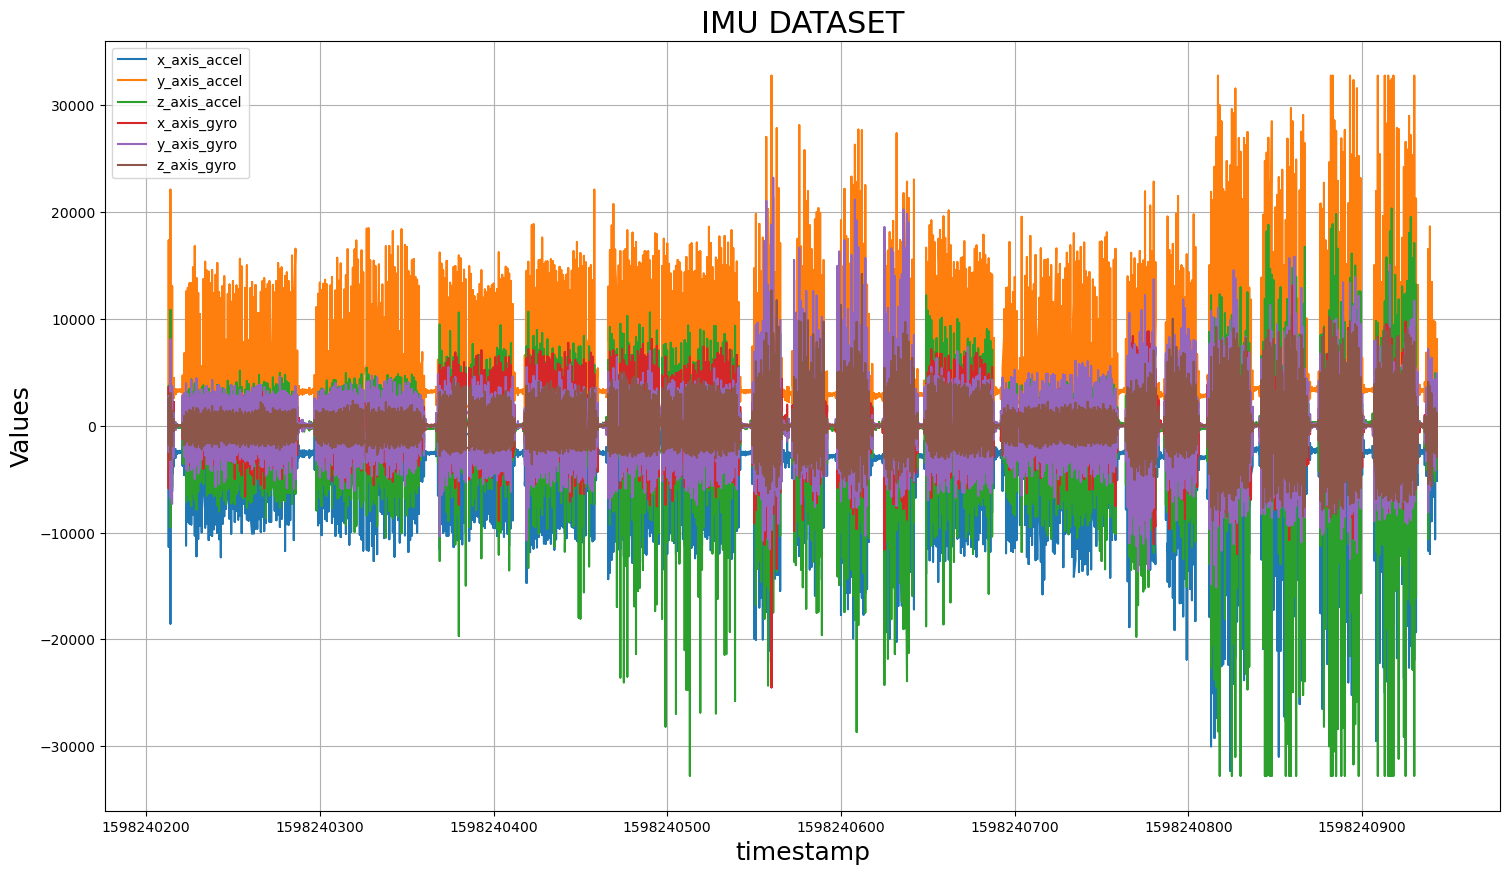

In [698]:
# Call the plot_dataframe function passing it our dataframes timestamp column for the X axis and every other column for our y values

imu_data_raw["time (seconds)"] = convert_time_series(imu_data_raw["timestamp"])

plot_dataframe(imu_data_raw["timestamp"],  imu_data_raw.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")


By the looks of it, our IMU dataset looks pretty straight forward:
- There are no null values
- We were able to correctly name the columns
- There are 71,000 samples of data
- All data values are integers
- The timestamp are unix time stamps
- We have created a new column value "time (seconds)" <br>
that tracks the time from the start of the data to <br>
any given point in seconds
<br>

One thing that stands out when visualizing this dataset is the start and end points of the data don't really match any other sections of the set, depending on <br>
what our activity data looks like, we may have to slice out these points to align the data more accurately. Another thing of note is the different sections of<br>
of the dataset. There appears to be 17 different movement sections with 4 or 5 different movement patterns, another thing to look out for when we are aligning <br>
our data.
Let's move onto our activity data set now and see what are working with and what we might have to fix

In [700]:
imu_data_raw.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro,time (seconds)
0,1598240213,-2402,1710,-380,-1413,-362,223,1
1,1598240213,-1880,1688,-420,-1469,-597,-23,1
2,1598240213,-1558,1568,-606,-1535,-872,-195,1
3,1598240213,-1154,1732,-654,-1293,-976,-335,1
4,1598240213,-452,2084,-754,-719,-940,-214,1


### Activity Dataset Inpection

In [704]:
check_for_null(activity_data_raw, "ACTIVITY DATA")

ACTIVITY DATA's NULL values 

image has 0 null values
xmin has 0 null values
ymin has 0 null values
xmax has 0 null values
ymax has 0 null values
label has 0 null values


In [705]:
activity_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   34 non-null     object 
 1   xmin    34 non-null     float64
 2   ymin    34 non-null     float64
 3   xmax    34 non-null     float64
 4   ymax    34 non-null     float64
 5   label   34 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.7+ KB


In [706]:
activity_data_raw.head()

,image,xmin,ymin,xmax,ymax,label
0,a3.mp4#t=0.0,868.943127,417.331032,919.139168,557.535077,Walking
1,a3.mp4#t=66.2,854.251592,330.392238,926.484935,564.882015,Standing
2,a3.mp4#t=75.4,855.475924,324.882034,929.545709,561.820810,Walking
3,a3.mp4#t=139.333333,849.966598,321.208565,928.933599,563.045281,Standing
4,a3.mp4#t=146.733333,855.475924,327.331004,935.667145,553.249400,Jogging


Similiarly like with the IMU dataset our Activity Dataset has a "not so straight forward" timestamp series, this is under the column named "image" and appears to <br>
be in the form of a string. We do need the time values from this set so that we can align our datasets later on. Fortunately it should be easy to create a clean<br>
set of data for time series from these values. Moving onto the other non-number series of data in the dataset, the labels. These will be our targets/labels/y-series<br>
that we will use to train our classifiers on later on, the rest of the data we don't need for this project. Let's fix our time series and then figure out what to plot.

In [708]:
# Create a list to append our new time values too
time = []

# Iterate through every row of the "image" column
for row in activity_data_raw.image:
    # Split the row on the "=" and append only the second element as this is float
    # value that appears after the equals and not the a3.mp4# that appears before.
    time.append(float(row.split("=")[1]))

# Add the new series to our dataframe
activity_data_raw["time"] = time
activity_data_raw.head()

,image,xmin,ymin,xmax,ymax,label,time
0,a3.mp4#t=0.0,868.943127,417.331032,919.139168,557.535077,Walking,0.000000
1,a3.mp4#t=66.2,854.251592,330.392238,926.484935,564.882015,Standing,66.200000
2,a3.mp4#t=75.4,855.475924,324.882034,929.545709,561.820810,Walking,75.400000
3,a3.mp4#t=139.333333,849.966598,321.208565,928.933599,563.045281,Standing,139.333333
4,a3.mp4#t=146.733333,855.475924,327.331004,935.667145,553.249400,Jogging,146.733333


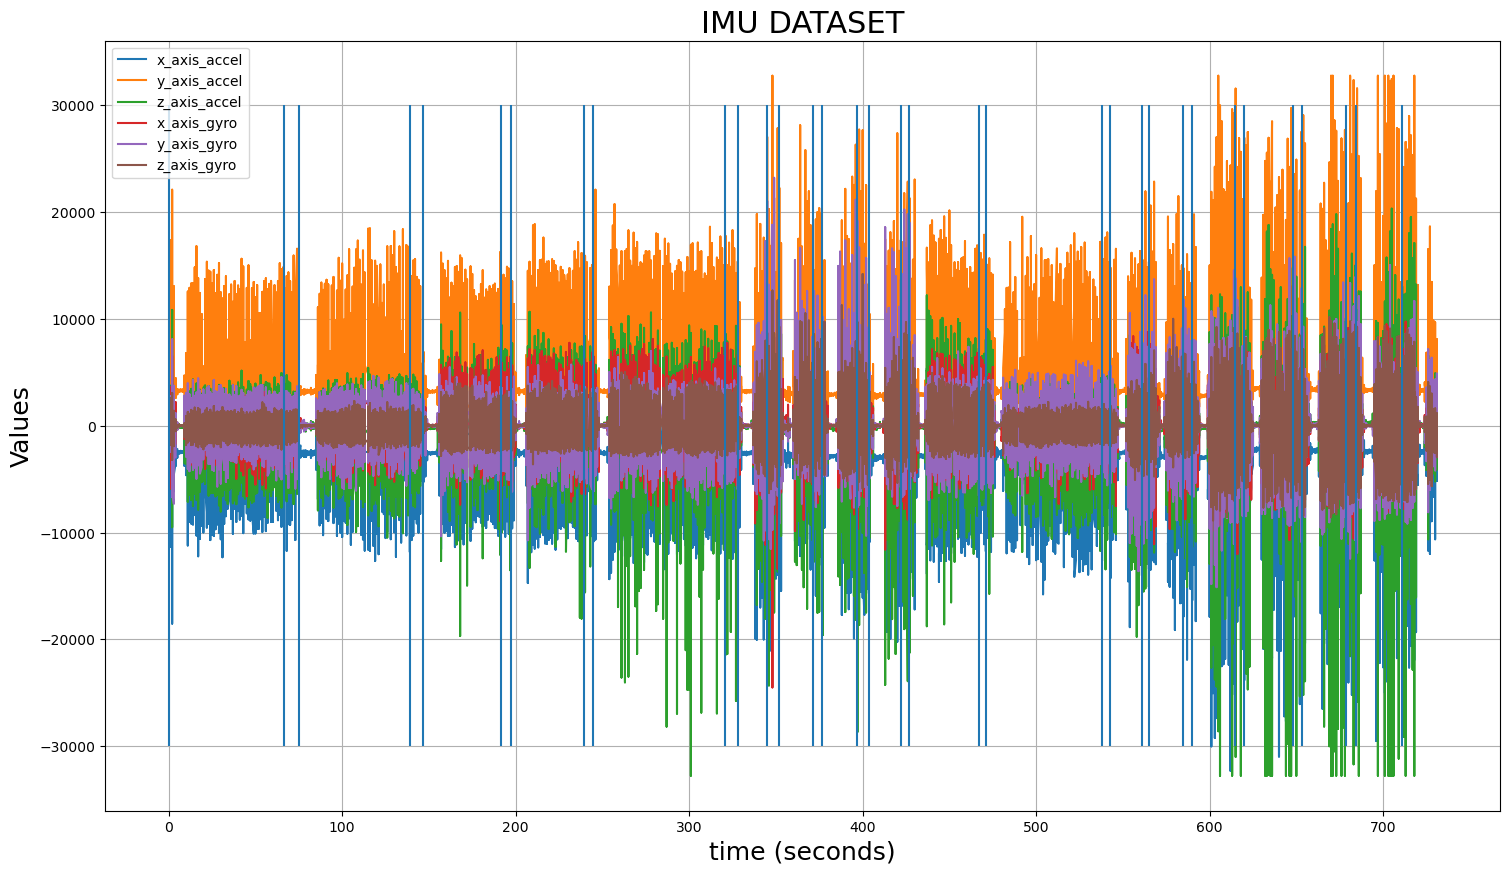

In [711]:
# Re-plot our IMU data and overlay the time points inthe activity dataset where the labels change
plot_dataframe(imu_data_raw["time (seconds)"],  imu_data_raw.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

# Add vertical lines for every activity change
plt.vlines(activity_data_raw["time"], -30000,30000)
plt.show()

In [714]:
# Printing the first value of our labels series
activity_data_raw.label[0]

'Walking'

Ok, so from the above plot we can see that our data is not aligned, judging by the small gaps between the vertical lines, and the fact that the first activity label is walking,<br>
the small blip of imu data at the start needs to be removed and we need our imu dataset to start a little later where the first section of consistancy begins. This should <br>
solve the alignment problem of our datasets, we also need to remove the last section of the imu data after the last section of consistancy. To find what values we need to slice <br>
out, we can use some trial and error passing in sliced sections of our imu dataset to our plot function and finding the exact values we need. Afterwards we can reassign our data<br>
frame without the uneeded rows of data and then re-adjust the time series again.

## Align and combined the activity and imu datasets using the activity transitions

In [719]:
# Slice up our imu data to remove unwanted start and end data
imu_processed = imu_data_raw.drop(["time (seconds)"], axis=1)[900:70000]

# reset the inde on the dataframe and drop the old index column
imu_processed = imu_processed.reset_index().drop("index", axis=1)
imu_processed.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro
0,1598240222,-2602,2848,-3576,-413,-51,-205
1,1598240222,-2850,2936,-3502,-315,-1,-123
2,1598240222,-3172,2890,-3450,-248,114,-17
3,1598240222,-3340,2772,-3240,-236,273,60
4,1598240222,-3346,2566,-3114,-287,469,83


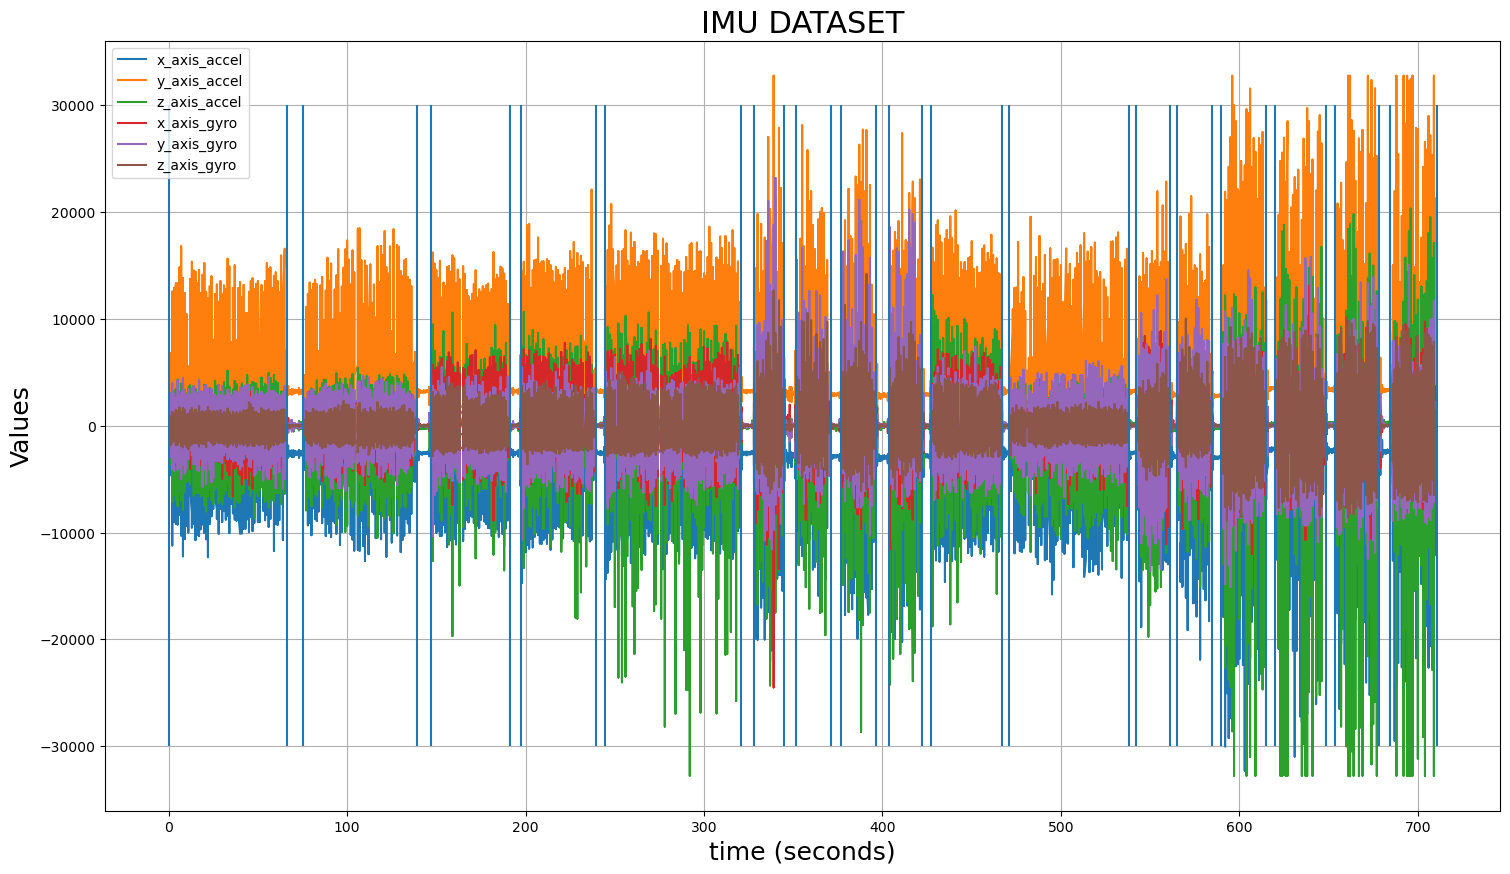

In [720]:
# Re-call the unix timestamp converter to re-adjust the time values
imu_processed["time (seconds)"] = convert_time_series(imu_processed["timestamp"])

plot_dataframe(imu_processed["time (seconds)"],  imu_processed.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

plt.vlines(activity_data_raw["time"], -30000,30000)
plt.show()

## Process the activity annotation data to assign a target activity to each data point within the IMU dataset.

In [722]:
# Setting an index for the activity label data row
index=1

# Creating a list to hold our activity labels
label=[]

# Iterating through every row of our imu dataset
for row in range(len(imu_processed)):

    # If the time for any given row in our imu data is less than the time in our activity data, we are appending the 
    # label from the activity data to our list of activity labels. Since the activity data's time starts at 0.00, this 
    # will throw our labels off by one row, so we minus 1 when appending to ensure we get the correct label assigned.
    if imu_processed["time (seconds)"][row] <= activity_data_raw.time[index]:
        label.append(activity_data_raw.label[index-1])
    # if the time for a given row from our imu data is greater then the current time in our activity data, we increment
    # the index by one, shifting our activity data to the next row, and continue to append whatever the activity label
    # is for that row to our activity list.
    else: 
        index +=1
        label.append(activity_data_raw.label[index-1])

# Create a new column in our imu dataset with our new labels which will be our targets for training.
imu_processed["label"] = label

# Sanity check to make sure all worked out
# for x in imu_processed["label"]:
#     print(x)
imu_processed.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro,time (seconds),label
0,1598240222,-2602,2848,-3576,-413,-51,-205,1,Walking
1,1598240222,-2850,2936,-3502,-315,-1,-123,1,Walking
2,1598240222,-3172,2890,-3450,-248,114,-17,1,Walking
3,1598240222,-3340,2772,-3240,-236,273,60,1,Walking
4,1598240222,-3346,2566,-3114,-287,469,83,1,Walking


So now we have our labels from our activity dataset appeneded to our imu dataset and everything is sliced up and aligned. We have time counted in seconds instead <br>
of unix timestamps, all we need to do before firing up our classifiers is to create some features from our data to train the classifiers on. This is what we will <br>
now turn our attention to in the next section.

## Calculate a set of features from the raw sensor data.

### Feature functions

#### Mean

In [727]:
# Function to calculate the mean for a series.

def calculate_mean(time_series, target_series, time_steps):
    """
    Calculates the mean of a pandas data series for a given period of time

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the mean on
    time_steps - The timeframe (i.e number of seconds) to calculate the mean over
    Returns:
    mean - A list of averages from the target_series calculated over the given time_steps. 
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # the cumulative total of values
    cumsum = 0
    # the number of entries that have been added together
    divisor = 0
    # list to hold the averages to be returned
    mean = []

    # iterate through every row of the dataframe
    for row in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the mean over
        if time_series[row] <= seconds:
            # add the rows data to the sum
            cumsum += target_series[row]
            # increment the divors by 1
            divisor += 1
        # otherwise if the above is not the case, then the next row of data's time has gone up
        # i.e we have reached the end of the calculatable period
        else:
            # safety net for divide by zero case
            if divisor != 0:
                # divide the total accumulated sum by the amount of entries, and append it to the list
                mean.append(round(cumsum/divisor, 6))
            else:
                # append 0 if there were no values, (we can deal with zero values later)
                mean.append(0)
            # Reset all of the variables for the next time step
            divisor = 0
            cumsum = 0
            cumsum += target_series[row]
            seconds += time_steps

    return mean

#### Max value

In [729]:
# Function to calculate the max values

def calculate_max(time_series, target_series, time_steps):
    """
    Calculates the max value of each step in a given time period in a pandas series

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the max on
    time_steps - The timeframe (i.e number of seconds) to calculate the max over
    Returns:
    max_ls - A list of max values from the target_series calculated over the given time_steps. 
    
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # Default value for max
    max = 0
    # list to hold the max values to be returned
    max_ls = []

    # iterate through every row in the dataseries
    for row in range(len(imu_processed["time (seconds)"])):

        target = target_series[row]
        # for every value in the current time step, check if the value of max is 
        # greater then the current row of data, if it isnt, replace it with the
        # current row of data for the current time step
        if time_series[row] <= seconds:
            if target > max:
                max = target
        else:
            # if the time_series is greater then the current time step, than append
            # the max value to the list, and increment the values for the next time step
            max_ls.append(round(max, 6))
            seconds += time_steps
            max = target

    return max_ls

#### Min value

In [731]:
# Function to calculate the min values

def calculate_min(time_series, target_series, time_steps):
    """
    Calculates the min value of each step in a given time period in a pandas series

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the min on
    time_steps - The timeframe (i.e number of seconds) to calculate the min over
    Returns:
    min_ls - A list of min values from the target_series calculated over the given time_steps. 
    
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # Default value for max
    min = 0
    # list to hold the max values to be returned
    min_ls = []

    # iterate through every row in the dataseries
    for row in range(len(imu_processed["time (seconds)"])):

        target = target_series[row]
        # for every value in the current time step, check if the value of max is 
        # greater then the current row of data, if it isnt, replace it with the
        # current row of data for the current time step
        if time_series[row] <= seconds:
            if target < min:
                min = target
        else:
            # if the time_series is greater then the current time step, than append
            # the max value to the list, and increment the values for the next time step
            min_ls.append(round(min, 6))
            seconds += time_steps
            min = target

    return min_ls

#### Signal Magnitude Area

In [733]:
# Function to calculate the signal magnitude area

def calculate_signal_magnitude_area(time_series, x, y, z, time_step):
    """
    Calculates the signal magnitude area of a given x, y and z pandas series for a
    given time period 

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    x - An x series of data to be used for hte signal magnitude 
    y - An y series of data to be used for the signal magnitude 
    z - An z series of data to be used for the signal magnitude 
    time_steps - The timeframe (i.e number of seconds) to calculate the signal magnitude over
    Returns:
    sma - A list of signal magnitude values from the x, y, z, target series calculated over the given time_steps. 
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_step
    # the cumulative total of values
    cumsum = 0
    # the number of entries that have been added together
    divisor = 0
    # a list to hold all of the signal magnitude features
    sma = []

    # Iterates through all rows of the time series
    for i in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the value over
        if time_series[i] <= seconds:
            # add the values of all three series to the cumulative total
            cumsum += x[i] + y[i] + z[i]
            # Increment the divisor by 1
            divisor += 1
        else:
            # if the divisor isnt 0
            if divisor != 0:
                # multiply negative values by -1 to get the absolute value
                if cumsum < 0:
                    cumsum = cumsum * -1
                # divide the absolute value by the number of samples and append result to the list
                sma.append(round(cumsum/divisor, 6))
            else:
                # append 0 if the divisor was 0, ie no samples over the time period
                sma.append(0)
            # reset all the values for the time step
            cumsum = 0
            cumsum += x[i] + y[i] + z[i]
            seconds += time_step

    return sma

#### Average Intensity

In [735]:
def calculate_average_intensity(time_series, x, y, z, time_step):
    """
    Calculates the average intensity of a given x, y and z pandas series for a
    given time period 

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    x - An x series of data to be used for the average intensity
    y - An y series of data to be used for the average intensity 
    z - An z series of data to be used for the average intensity
    time_steps - The timeframe (i.e number of seconds) to calculate the average intensity over
    Returns:
    ai - A list of average intensity values from the x, y, z, target series calculated over the given time_steps. 
    """
    seconds = time_step
    xsum, ysum, zsum = 0, 0, 0

    divisor = 0
    # list to hold the average intensity values
    ai = []
    for i in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the value over
        if time_series[i] <= seconds:
            
            xsum += x[i]
            ysum += y[i]
            zsum += z[i]
            # Increment the divisor by 1
            divisor += 1
        else:
            # if the divisor isnt 0, square the values
            if divisor != 0:
                xsum = xsum**2
                ysum = ysum**2
                zsum = zsum**2

                # TAKE THE SQUARE ROOOOT
                sqrt = math.sqrt(xsum+ysum+zsum)

                # divide the value by the amount of samples and add it to the list
                ai.append(round(sqrt/divisor, 6))
            else:
                # Append 0 if the divisor is 0, i.e there were no samples
                ai.append(0)
            # Reset all the values for the next time_step
            xsum, ysum, zsum = 0, 0, 0

            xsum += x[i]
            ysum += y[i]
            zsum += z[i]
            seconds += time_step
    return ai

#### Acitivity Labels

In [737]:
# Function for activity labels

def assign_labels(time_series, target_series, time_steps):
    """
    Assigns the activity value of each step in a given time period in a pandas series

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of our activity values to assign 
    time_steps - The timeframe (i.e number of seconds) to calculate which activity is being performed
    Returns:
    Activity - A list of activity values from the target_series calculated over the given time_steps. 
    
    """
    
    seconds = time_steps

    activity = []
    # Iterate through all rows of the dataframe and assign a target activity label for each time step
    for row in range(len(time_series)):
        # similiar to the features functions above, if the current row of the time series has the same
        # value of time as the time_step, then continue to the next row
        if time_series[row] <= seconds: continue
        # if the value in the time series is now greater then the current time_step, then append the last
        # activity to the list, this will be the label for that time_step
        else:
            # Assign the last label to the list
            activity.append(target_series[row-1])
            seconds += time_steps
    return activity

### Create a new Dataframe made of our new features

In [739]:
# Create a new dataframe to hold all of our features
imu_features = pd.DataFrame()

# Set a time step to calculate all features over, this is the amount of seconds that each feature should be calculated 
# over, be warned, when increasing this number it doesn't take long for the accuracy of the features to drop 
# dramatically as you are calculating over longer time periods with activity changes.
time_steps = 1

# time series of values
time_series = imu_processed["time (seconds)"]

# Mean features
imu_features["x_accel_mean"] = calculate_mean(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_mean"] = calculate_mean(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_mean"] = calculate_mean(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_mean"] = calculate_mean(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_mean"] = calculate_mean(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_mean"] = calculate_mean(time_series, imu_processed["z_axis_gyro"], time_steps)

# max features
imu_features["x_accel_max"] = calculate_max(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_max"] = calculate_max(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_max"] = calculate_max(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_max"] = calculate_max(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_max"] = calculate_max(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_max"] = calculate_max(time_series, imu_processed["z_axis_gyro"], time_steps)

# min features
imu_features["x_accel_min"] = calculate_min(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_min"] = calculate_min(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_min"] = calculate_min(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_min"] = calculate_min(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_min"] = calculate_min(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_min"] = calculate_min(time_series, imu_processed["z_axis_gyro"], time_steps)

# Signal magnitude area
imu_features["sma_accel"] = calculate_signal_magnitude_area(time_series, imu_processed["x_axis_accel"], imu_processed["y_axis_accel"], imu_processed["z_axis_accel"], time_steps)
imu_features["sma_gyro"] = calculate_signal_magnitude_area(time_series, imu_processed["x_axis_gyro"], imu_processed["y_axis_gyro"], imu_processed["z_axis_gyro"], time_steps)

# average intensity
imu_features["ai_accel"] = calculate_average_intensity(time_series, imu_processed["x_axis_accel"], imu_processed["y_axis_accel"], imu_processed["z_axis_accel"], time_steps)
imu_features["ai_gyro"] = calculate_average_intensity(time_series, imu_processed["x_axis_gyro"], imu_processed["y_axis_gyro"], imu_processed["z_axis_gyro"], time_steps)

# Label feature
imu_features["target"] = assign_labels(time_series, imu_processed["label"], time_steps)

# Finally add time in seconds to our new dataframe
time = []
steps = 1
# iterate through all row of activites and append a value of time
for row in range(len(imu_features)):
    time.append(steps)
    steps += 1

# add the list to the features dataframe 
imu_features["time"] = time


### Plotting our Features along with the activity markers

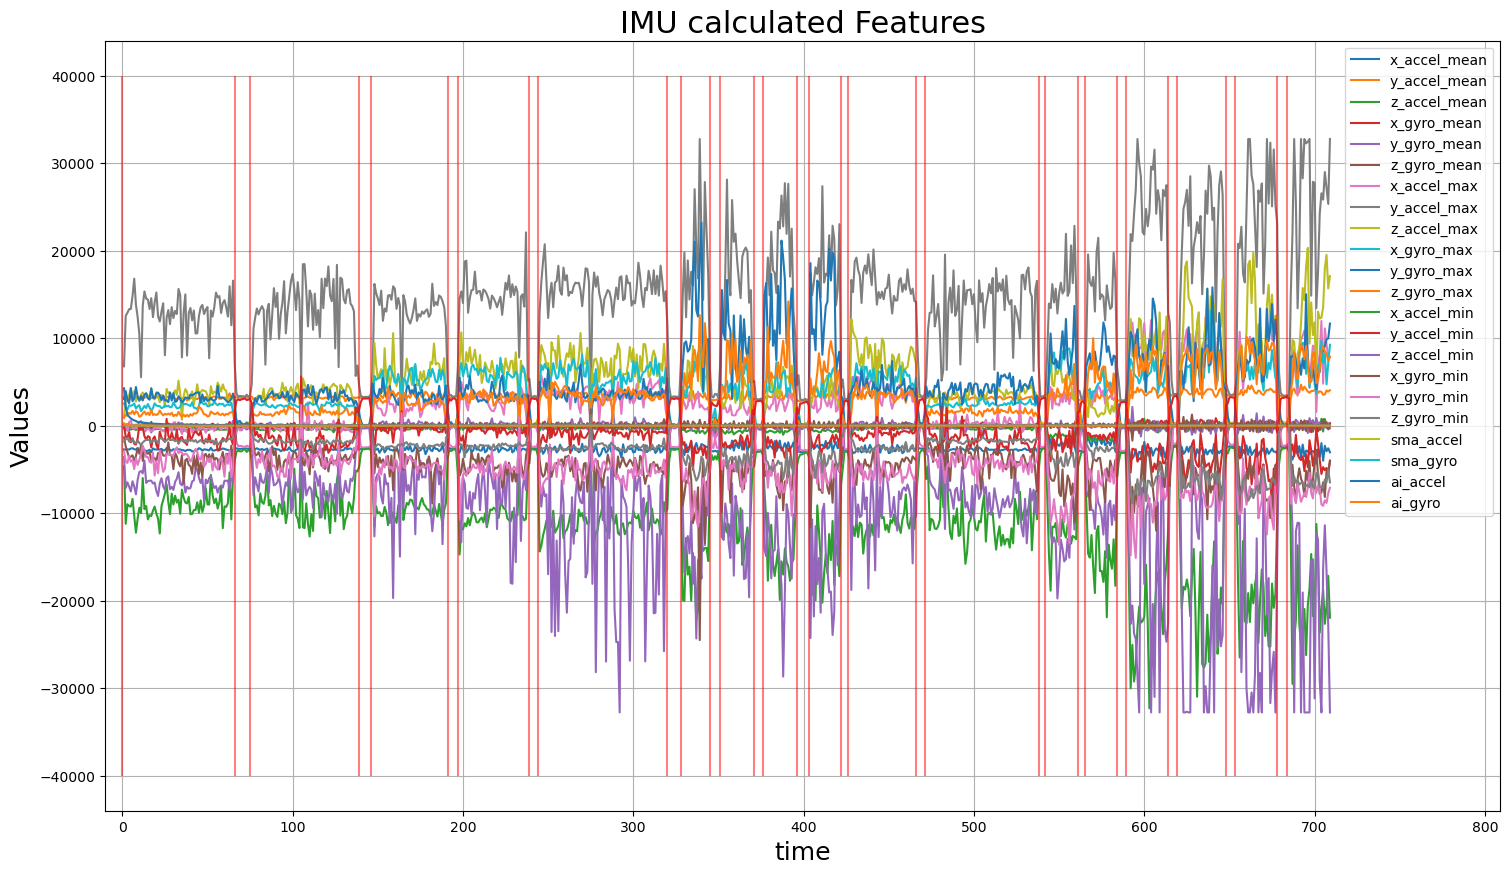

In [741]:
# Since the time steps can change depending on if we want 1, 2, 3, etc second itervals to calculate
# our features over, we have to make sure the activity transitions move with the time steps, below
# is a loop that creates a list of activity transitions depending on the value in the data series
activity_markers = [0]
# Set a variable to keep track of the current activity we are up to
current_label = imu_features["target"][0]
# iterate through all rows of the target labels, ie "walking", "jogging", etc
for row in range(len(imu_features["target"])):
    # if the current activity isnt the same as the target row, append the value to the list and 
    
    if current_label != imu_features["target"][row]:
        activity_markers.append(row)
        # change the current activity to the freshly added value to our list
        current_label = imu_features["target"][row]

# plot the new dataframe with the calculated features and add the vertical lines from the activity series to check it lines up
plot_dataframe(imu_features["time"], imu_features.drop(["target", "time"], axis=1), "IMU calculated Features")

# Plot the vertical lines associated with our activity transitions
plt.vlines(activity_markers, -40000,40000, color="r", alpha=0.5)
plt.xlim(-10, len(imu_features) + 100)
plt.show()

Ok so from the above plot we can now see that we were successfully able to transform our data from raw values into a set of features to be used <br>
for classfication. We chose to use the mean, max, min, signal magnitude, and average intensity values for each axis. Now onwards to training our<br>
classifiers!


## Apply a machine learning workflow to train classifiers

In [745]:
# Check to see what data we are working with
imu_features.head()

,x_accel_mean,y_accel_mean,z_accel_mean,x_gyro_mean,y_gyro_mean,z_gyro_mean,x_accel_max,y_accel_max,z_accel_max,x_gyro_max,...,z_accel_min,x_gyro_min,y_gyro_min,z_gyro_min,sma_accel,sma_gyro,ai_accel,ai_gyro,target,time
0,-2703.360000,3299.400000,-318.740000,188.040000,-120.140000,-54.690000,0,6784,994,2548,...,-3576,-1334,-2889,-1814,277.300000,13.210000,4277.357927,229.746942,Walking,1
1,-2733.737374,3318.101010,-485.373737,25.141414,-205.969697,42.070707,32,12562,2822,2076,...,-7110,-2361,-4045,-1564,49.246231,69.030151,2152.385132,105.328267,Walking,2
2,-2708.755556,3033.000000,-469.800000,-264.022222,-476.966667,122.222222,-592,12910,3198,1857,...,-6478,-3004,-4256,-1381,45.328720,192.695502,1274.808190,173.988927,Walking,3
3,-2720.536082,3024.783505,-473.092784,-190.546392,-331.020619,-48.762887,394,13320,3450,2331,...,-6962,-3631,-3419,-1808,42.430052,143.321244,1029.220804,96.760256,Walking,4
4,-2602.424242,3157.797980,-434.949495,-56.757576,-96.606061,-65.707071,596,13342,4324,2275,...,-7520,-3540,-4117,-1762,24.581443,44.717526,839.975424,26.513755,Walking,5


### Encoding, Splitting and Scaling Our Data

In [747]:
# Dropping the target and time columns from the feature set
X = imu_features.drop(columns=["target", "time"])
y = imu_features["target"]

#Converting the string labels(e.g Walking, Running) into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

#Scaling the features, allowing the input data to be normalized
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Training Our Classifiers

In this section, I decided to utilize a variety of classifiers including KNN, SGD, Decision Trees and RandomForest. Each of these classifiers have different strengths and handle data in unique ways.

### Knn classifier

In [751]:
#n_neighbours = 5, the model will consider 5 data points nearby, the default value.
knn_classifier = KNeighborsClassifier(n_neighbors=5)

#Fitting the classifier into the training data
knn_classifier.fit(X_train, y_train)

#Predicting the labels for the test set using the classifier
y_pred_knn = knn_classifier.predict(X_test)

KNN(K-Nearest Neighbour) classifier was chosen due to its simplicity and accuracy. However since KNN is a non parametric algorithm, it can be sensitive to irrelevant features affecting <br>
the distance between points. Which is why feature selection and tuning the number of neighbours to 5 is crucial. Anything less than 5 may affect the model becoming too sensitive to noise<br>
in our dataset, which can lead to overfitting. On the other hand, anything larger than 5 can cause the model to become too generalized, causing underfitting. A value of 5 for the neighbours<br>
should strike a balance to avoid both overfitting and underfitting.

### Decision Trees

In [754]:
#Decision tree classifier, 2 max depth and random state of 42 to ensure the results are reproducible 
decision_tree = DecisionTreeClassifier(max_depth = 2, random_state=42)

#Fitting the classifier into the training data
decision_tree.fit(X_train, y_train)

#Predicting the labels for the test set using the classifier
y_pred_tree = decision_tree.predict(X_test)

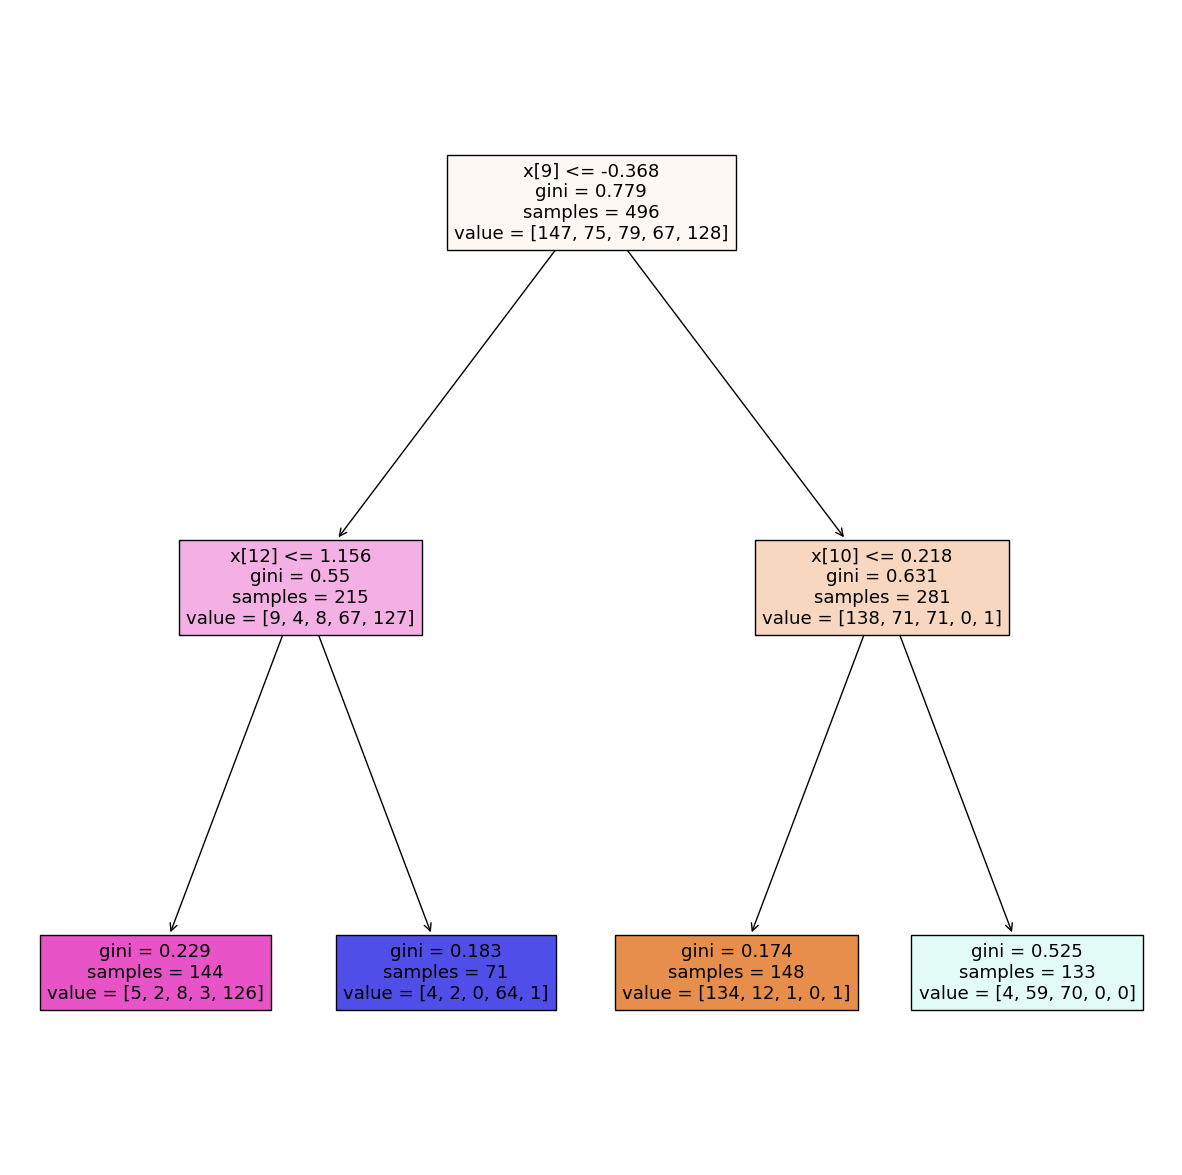

In [755]:
#Visualizing the decision tree classifier
plt.figure(figsize = (15, 15))
plot_tree(decision_tree, filled=True)
plt.show()

### SGD Classifier

In [757]:
# Stochastic Gradient Descent (SGD) Classifier
sgd_classifier = SGDClassifier(random_state=42)

# Fit the SGD classifier to the training data
sgd_classifier.fit(X_train, y_train)

# Predict the labels for the test set using the trained SGD classifier
y_pred_sgdc = sgd_classifier.predict(X_test)


The Stochastic Gradient Descent (SGD) Classifier was chosen for this dataset due to its effectiveness in handling larger data sets. This classifier utilizes an online learning algorithm, <br>
performing updates to its model parameters with each training example, allowing it to be faster and scalable. The random state number of 42 is chose as a standard practice for reproducing <br>
the exact results.

### RandomForest Classifier

In [760]:
# Random Forest Classifier, n_estimators(the number of trees in the forest)
rf_classifier = RandomForestClassifier(n_estimators=100, max_features='sqrt',random_state=42)

# Fit the Random Forest classifier to the training data
rf_classifier.fit(X_train, y_train)

# Predict the labels for the test set using the trained Random Forest classifier
y_pred_rf = rf_classifier.predict(X_test)

The randomforest classifier was chosen for its flexibility and versality for both regression and classification tasks. It is a strong choice for reducing overfitting data through averaging <br>
multiple decision trees. The n_estimators=100, constructs 100 trees and was chosen to provide a good balance between accuracy and computational requirements. A higher number of trees would <br>
increase accuracty, though at the cost of longer training times.

## Performance Metrics for classifiers

In this section I performed feature selection to determine the best two features for the SGDC and KNN classifier. This is achieved through iterating through each of the classifiers and <br>
evaluating the feature combinations.<br>

Specific feature selection can be essential as not all features within a dataset would contribute effectively to the prediction task. Through finding the move relevant features and focusing<br>
on them, we can improve the performance of the classifiers and increase accuracy.

For KNN, the features with the higher F1 score were 6 and 10.

For SGD, the features with the higher F1 score were 6 and 11.

### Best Feature Selection

In [765]:
# Define the classifiers we want to test
classifiers = {
    'SGDC' : sgd_classifier,
    'KNN' : knn_classifier,   
}

# Determine the number of features in the dataset
num_features = X_train.shape[1]

# Loop through each classifier in the classifiers dictionary
for name, clf in classifiers.items():
    print(f"{name} Feature Selection:\n")

    #Storing the best results 
    best_mean_f1 = 0
    best_f1 = 0
    best_f2 = 0

    ##Testing every combination of pairs of features
    for f1 in range(num_features):
        for f2 in range(num_features):

            if f1 == f2:
                continue
            features_idx_to_use = [f1, f2]

            # Select the two features 
            X_train_selected = X_train[:, features_idx_to_use]

            # Train the classifier
            clf.fit(X_train_selected, y_train)
            y_predicted = cross_val_predict(clf, X_train_selected, y_train, cv=3)

            # Calculate the F1 score
            current_f1 = np.mean(f1_score(y_train, y_predicted, average='macro'))

            # Update the best feature combination
            if current_f1 > best_mean_f1:
                best_f1 = f1
                best_f2 = f2
                best_mean_f1 = current_f1

                # Print only features that score higher F1
                print(f"First Feature: {best_f1}\t Second Feature: {best_f2}\t F1 score: {current_f1:.6f}")
    
    # Print the best result for this classifier
    print(f"\nBest Features for {name}: First Feature: {best_f1}, Second Feature: {best_f2} with F1 Score: {best_mean_f1:.6f}\n")
    

SGDC Feature Selection:

First Feature: 0	 Second Feature: 1	 F1 score: 0.316106
First Feature: 0	 Second Feature: 2	 F1 score: 0.392664
First Feature: 0	 Second Feature: 6	 F1 score: 0.597761
First Feature: 0	 Second Feature: 11	 F1 score: 0.626135
First Feature: 0	 Second Feature: 17	 F1 score: 0.700921
First Feature: 6	 Second Feature: 10	 F1 score: 0.722666
First Feature: 6	 Second Feature: 11	 F1 score: 0.753180

Best Features for SGDC: First Feature: 6, Second Feature: 11 with F1 Score: 0.753180

KNN Feature Selection:

First Feature: 0	 Second Feature: 1	 F1 score: 0.644934
First Feature: 0	 Second Feature: 6	 F1 score: 0.833732
First Feature: 0	 Second Feature: 17	 F1 score: 0.844711
First Feature: 2	 Second Feature: 11	 F1 score: 0.855804
First Feature: 2	 Second Feature: 17	 F1 score: 0.868746
First Feature: 6	 Second Feature: 10	 F1 score: 0.888159

Best Features for KNN: First Feature: 6, Second Feature: 10 with F1 Score: 0.888159



After identifying the best features, the feature names are extracted from the dataset X.columns.

For SGDClassifier, the best features are:
x_accel_max (Feature 6)
z_gyro_max (Feature 11)

For KNeighborsClassifier, the best features are:
x_accel_max (Feature 6)
y_gyro_max (Feature 10)

Printing the best features can provide us insight in which specific features are the most relevant for the two classifiers that we are training.

In [767]:
feature_names = X.columns
# For SGDC
best_feature_sgdc_1 = feature_names[6] 
best_feature_sgdc_2 = feature_names[11] 

print(f"Best Features for SGDC: {best_feature_sgdc_1} and {best_feature_sgdc_2}")

# For KNN
best_feature_knn_1 = feature_names[6]  
best_feature_knn_2 = feature_names[10] 

print(f"Best Features for KNN: {best_feature_knn_1} and {best_feature_knn_2}")


Best Features for SGDC: x_accel_max and z_gyro_max
Best Features for KNN: x_accel_max and y_gyro_max


### Retrain Knn an SGD Classifier's on their best Features

In [769]:
# We need to idividually assign the two best features to each classifier as they use slightly different "best features"
# instead of generalizing the name we just have to be more specific
sgdc_X_train_selected = X_train[:, [6, 11]]
sgdc_X_test_selected = X_test[:, [6, 11]]

knn_X_train_selected = X_train[:, [6, 10]]
knn_X_test_selected = X_test[:, [6, 10]]

# Retrain the Knn with the best features found above
knn_classifier.fit(knn_X_train_selected, y_train)
y_pred_knn = knn_classifier.predict(knn_X_test_selected)

# Retrain the SGD with the best features found above
sgd_classifier.fit(sgdc_X_train_selected, y_train)
y_pred_sgdc = sgd_classifier.predict(sgdc_X_test_selected)

### Confusion Matrix comparison

In [771]:
# Calculate the confusion matrix for each classifier
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_sgdc = confusion_matrix(y_test, y_pred_sgdc)
cm_rf = confusion_matrix(y_test, y_pred_rf)

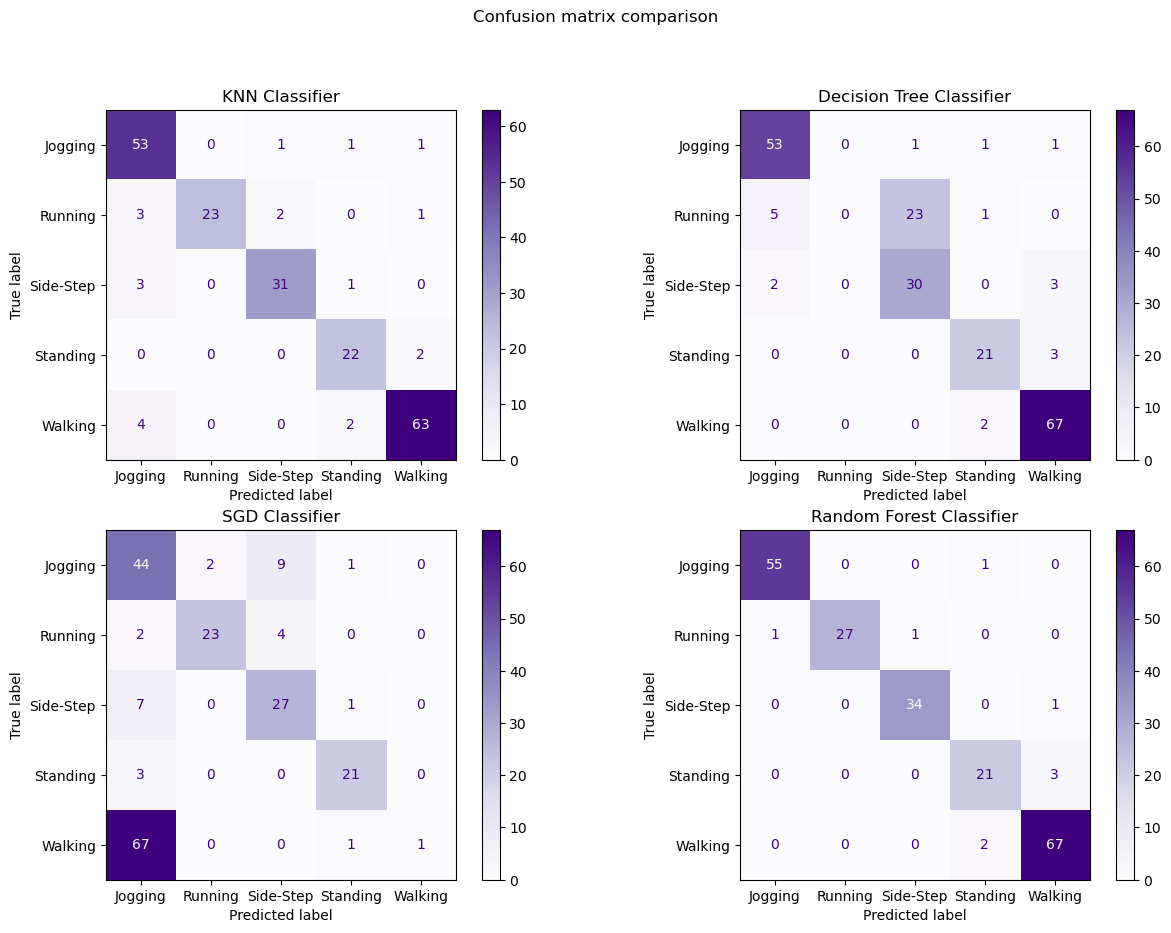

In [772]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Get unique class labels to display on the confusion matrix
class_labels = label_encoder.classes_

# Dictionary containing each classifiers confusion matrix
cm_dict = {"KNN Classifier": cm_knn,
          "Decision Tree Classifier": cm_tree,
          "SGD Classifier": cm_sgdc,
          "Random Forest Classifier": cm_rf
          }

# Keep track of where we are upto in our subplot
row, col = 0, 0

# Iterate through each entry in the dictionary
for name, cm in cm_dict.items():
    
    # Displays for each of the classifers
    display_knn = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    display_knn.plot(ax=axes[row, col], cmap=plt.cm.Purples)
    axes[row, col].set_title(name)

    # Controls the row and column for the subplot
    col += 1
    if col == 2:
        row += 1
        col = 0

plt.suptitle("Confusion matrix comparison")
plt.show()

From the above comparison of confusion matrices, we observe how each of the classifiers performed on the different activities.

The KNN classifier has a good performance overall, with a few misclassifications in running and side stepping.<br>
The Decision Tree classifier has a similar performance compared to the KNN classifier, with few misclassifications in side stepping and walking<br>
The SGD classifier is the weakest perfoamce with much more misclassifications then all the other classifiers, specifically walking and jogging<br>
The random forest classifier overall has the best performance out of the other three, with the fewest misclassifications on running, walking and jogging.


In [774]:
# A function for calculating the performance metrics of classifiers

def performance_metrics(classifiers, y_train, y_test):
    """
    Calculates the a specific set of scores for a given set of classifiers 
    passed in as a dictionary, on a passed in X and y set.
    Params:
    classifiers - a dictionary with classifier names as keys and a list as a value, 
    containing a classifier and it's X series trained and test sets.
    y_train - the y set to fit the classifier with.
    y_test - the y set to test the classifier on.
    """

    # Iterate through each key and value of the dictionary
    for name, clf in classifiers.items():

        # Assign each element from the list value to a new variable
        classifier = clf[0]
        X_train = clf[1]
        X_test = clf[2]
 
        classifier.fit(X_train, y_train)  #Training the classifier
        y_pred = classifier.predict(X_test)  #Predicting on the test set

        #Calculating the metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division = False)
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        #Printing the results
        print(f"Classifier: \t{name}")
        print(f"Accuracy: \t{round(accuracy,5)}")
        print(f"Precision: \t{round(precision,5)}")
        print(f"Recall: \t{round(recall,5)}")
        print(f"F1 Score: \t{round(f1,5)}")
        print('\n')

#Define classifiers
classifiers = {
    'SGDC' : [sgd_classifier, sgdc_X_train_selected, sgdc_X_test_selected],
    'RF' : [rf_classifier, X_train, X_test],
    'KNN' : [knn_classifier, knn_X_train_selected, knn_X_test_selected],
    'dTREE' : [decision_tree, X_train, X_test],
}

#Call the performance_metrics function with the classifiers
performance_metrics(classifiers, y_train, y_test)

Classifier: 	SGDC
Accuracy: 	0.5446
Precision: 	0.76554
Recall: 	0.64795
F1 Score: 	0.59341


Classifier: 	RF
Accuracy: 	0.95775
Precision: 	0.95445
Recall: 	0.94612
F1 Score: 	0.95


Classifier: 	KNN
Accuracy: 	0.90141
Precision: 	0.9079
Recall: 	0.89099
F1 Score: 	0.89608


Classifier: 	dTREE
Accuracy: 	0.80282
Precision: 	0.63686
Recall: 	0.72992
F1 Score: 	0.67643




Above is the summary of perfomance metrics across all the classifiers performed on in terms of accuracy, precision, recall, and F1 score

The SGD classifier shows the weakest performance overall. Although precision is a bit high at 0.76554, the recall is still low.

The random forest classifier has the strongest performance overall with an accuracy of 0.95775 and a nearly perfect F1 score of 0.95. The precision and recall are relatively strong, which shows its effectiveness in the dataset

The KNN classifier also performs relatively well with an accuracy of 0.90141 and an F1 score of 0.89608.

The decision tree has decent performance, with an accuracy of 0.80282 and an F1 score of 0.67643

## Re-Training our classifiers with hyper-parameter optimization 

### Decision tree

#### Finding optimal hyperparameter max depth

Max Depth is the maximum number of levels allowed in the decision tree. By adjusting the max depth, we can either run into the problem of underfitting or overfitting. Therefore we <br>
aim to determine to optimal max depth so that it avoids the risk of not capturing the underlying patterns of the dataset enough (underfitting) and capturing noise (overfitting).  


In [781]:
# Setting the default variables needed for optimizing
best_max_depth = 1
best_mean_f1 = 0
f1_set = np.zeros(20)
max_depth_range = range(1, 20)

# Iterate through each value in the max_depth_range
for max_depth_val in max_depth_range:

    # Assign the max_depth_value to the decisiontree and calculate it's f1 score
    clf = DecisionTreeClassifier(max_depth=max_depth_val, random_state=42)
    y_predicted = cross_val_predict(clf, X_train, y_train, cv=5)
    current_f1 = np.mean(f1_score(y_train, y_predicted, average='macro')) 
    f1_set[max_depth_val] = current_f1
    
    # Reassign the default variables assigned above if the scores increase
    if current_f1 > best_mean_f1:
        best_max_depth = max_depth_val
        best_mean_f1 = current_f1
        best_clf = clf 

# Fit the best classifier to our decision tree
best_clf.fit(X_train, y_train)

print(f"The optimal max depth is: {best_max_depth}")

The optimal max depth is: 3


#### Performance metrics for re-trained decision tree

In [783]:
# Calculate the predictions for the tuned decision tree
y_test_predicted = best_clf.predict(X_test)

# Dictionary containing the original decision tree and the tuned dictionary
dtree_classifiers = {"Decision Tree (Pre tuning of 2)": [decision_tree, X_train, X_test],
               "Decision Tree (Max Depth Tuned of 3)": [best_clf, X_train, X_test]
              }

# Using our performance metrics function to visualise the score from before and after training
performance_metrics(dtree_classifiers, y_train, y_test)

Classifier: 	Decision Tree (Pre tuning of 2)
Accuracy: 	0.80282
Precision: 	0.63686
Recall: 	0.72992
F1 Score: 	0.67643


Classifier: 	Decision Tree (Max Depth Tuned of 3)
Accuracy: 	0.91549
Precision: 	0.9135
Recall: 	0.894
F1 Score: 	0.90246




Decision tree Pre-tuning vs Post-tuning:


The accuracy improved from 0.80 to ~0.92, ~12% increase.<br>
Precision improved from ~0.64 to 0.91, ~27% increase.<br>
Recall score improved from ~0.73 to 0.89, 16% increase.<br>
F1 score improved from ~0.68 to 0.90, 22% increase. <br>

Precision had the most significant improvement of 27% increase, indicating that the model is predicting more positive instances correctly.<br>
Followed by f1 score (22% increase), which reflects the increase of recall and precision scores<br>,recall score (16% increase): indicates increase in ability to correctly detect ALL positive instances<br> 
and accuracy (12% increase): reflecting an increase in the proportion of correct prediction out of all predictions i.e. overall performance.

Note that improvements in accuracy do not account for class distribution, and therefore are not taken into much account when assessing overall effectiveness of model performance. 





#### Visualisation of re-learnt decision tree

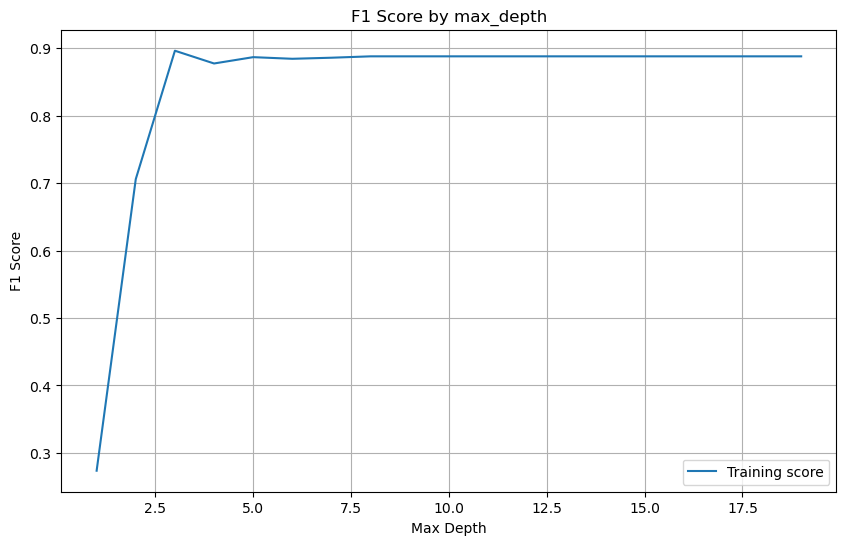

In [786]:
# Create a figure to plot on 
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scores from fitting each max depth
plt.plot(max_depth_range, f1_set[1:20], label="Training score")

# Set the title and labels to make the plot look pretttty-ish
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel('Max Depth')
ax.set_ylabel('F1 Score')
ax.set_title("F1 Score by max_depth")
plt.grid()
plt.legend()
plt.show()

This graph supports the notion that max depth of 3 is optimal for better model performance, as f1 score is higher here just before plateauing. Indicating that increasing max depth after 3 <br>
does not benefit the f1 score as it can lead to overfitting.

### kNN

#### Finding optimal hyperparameter k 

Selecting the right hyperparameter k prevents overfitting (k is too small) and underfitting (k is too large). We use cross validation to test different k values to find the one that best <br>
optimises model performance without overfitting/underfitting.

In [791]:
# Create a list to score all of the k scores
k_scores = []

# Iterate through 100 scores
for k in range(1,100):

    # Fit a knn classifier with each k in the range
    knn = KNeighborsClassifier(n_neighbors=k)

    # Run cross val on the classifier and append the score to the k list of scores
    scores = cross_val_score(knn,knn_X_train_selected, y_train,cv=10,scoring='f1_macro')
    k_scores.append(scores.mean())

# Pick the highest score as the optimal K value
optimal_k = np.argmax(k_scores)
print("Optimal k with cross-validation: ", np.argmax(k_scores))

Optimal k with cross-validation:  25


#### Performance metrics for re-trained kNN

In [793]:
# Creating our tuned knn_classifier with optimal k
knn_tuned = KNeighborsClassifier(n_neighbors=optimal_k)
knn_tuned.fit(knn_X_train_selected, y_train)
predictions = knn_tuned.predict(knn_X_test_selected)

In [794]:
# A dictionary for the knn this time
knn_classifiers = {"KNN (Pre tuning, k=5)": [knn_classifier, knn_X_train_selected, knn_X_test_selected],
               "KNN (Nearest Neighbours tuned, k=25)": [knn_tuned, knn_X_train_selected, knn_X_test_selected]
              }

# Using the performance metrics function 
performance_metrics(knn_classifiers, y_train, y_test)

Classifier: 	KNN (Pre tuning, k=5)
Accuracy: 	0.90141
Precision: 	0.9079
Recall: 	0.89099
F1 Score: 	0.89608


Classifier: 	KNN (Nearest Neighbours tuned, k=25)
Accuracy: 	0.89671
Precision: 	0.90468
Recall: 	0.88742
F1 Score: 	0.89302




The accuracy of the pre tuned model has a slightly higher accuracy compared to the post-tuned. Indicates the pre-tuned model makes better overall predictions, however this <br>
difference is subtle (~0.005%). <br>

The precision score is also slightly higher in the pre-tuned model (~ 0.0032%), it is a bit better at identifying all positive instance cases amongst predicted positive cases.<br>
Recall is also higher in the pre-tuned model, and this is a subtle difference (~0.004%),identifies actual positive instances a bit better.<br>
Similarly f1 score is improved in the pre-tuned model, as it reflects precision and recall scores.<br>

Although, the pre-tuned model seems to have better performance metrics than the post-tuned model, this is not indicative of actual model performance. The pre-tuned model likely <br>
overfits the train data, hence why it seems to perform well in the specific set of test data. Meaning it may not generalise well to other data. The post-tuned model, with optimal <br>
k=25, should lead to better performance as it is more generalised and is less influenced from individual data points. 


#### Visualisation of re-learnt kNN

##### Functions for visualization

In [798]:
# Function to plot confusion matrix's side by side for comparison

def plot_confusion_matrix(classifiers, y):
    """
    Plots upto two confusion matrix's side by side. Takes in a dictionary of 
    classifiers with their names as keys and their X test set as the value.
    Params:
    Classifiers - a dictionary of classifiers with names as keys and X_test 
    sets as values
    y - the y test set of values to predict values for
    """
    # Create a subplot for our matrix's
    fig, ax = plt.subplots(1,2, figsize=(14, 7))

    # Set columns to 0
    col = 0

    # iterate through each classifier
    for name, value in classifiers.items():

        # assign dict values to variables
        clf, X_test = value[0], value[2]
        
        # Get the predicted labels for a classifier
        y_pred = clf.predict(X_test)

        # Plot the confusion matrix
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_ , ax=ax[col])

        # set the title
        ax[col].set_title(name)

        # Increment column by 1
        col += 1

In [799]:
# Function to plot boundaries
def plot_boundaries(classifiers, y_train, y_test):
    """
    Takes in a dictionary of classifiers and plots the decision boundaries for each
    classifier as well as the training points and test points.
    Params:
    classifiers - a dictionary of classifiers to be plotted
    """
    # Create a figure to hold our plots
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Moving your colour maps up here to initalize them first before calling them in the colormesh
    cmap_bold = ListedColormap(['Red', 'Green', 'Blue', 'Yellow', 'darkorange'])
    cmap_light = ListedColormap(['LightPink', 'LightGreen', 'LightBlue', 'Wheat', 'Sienna'])

    # Create a list of labels for our plots legend
    label = [i for i in label_encoder.classes_]
    
    # Keep track of the column number
    col = 0

    # Iterate through all the classifiers passed in
    for name, classifier in classifiers.items():

        clf, X_train, X_test = classifier[0], classifier[1], classifier[2]

        # Setting the boundaries for the knn classifiers on the two best features
        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

        # Set their Z value
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the boundaries and points for the classifier, the training and test sets as well as add labels 
        ax[col].pcolormesh(xx, yy, Z, cmap=cmap_light)
        ax[col].contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
        scatter = ax[col].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='x')
        ax[col].set_xlabel('x_accel_max')
        ax[col].set_ylabel('y_gyro_max')
        
        # Set the title
        ax[col].set_title(name)
        
        # Add a legend to the plot
        ax[col].legend(handles = scatter.legend_elements()[0], labels = label)

        # Increment the column by 1 for the next classifier
        col += 1

#### Confusion Matrix's comparison

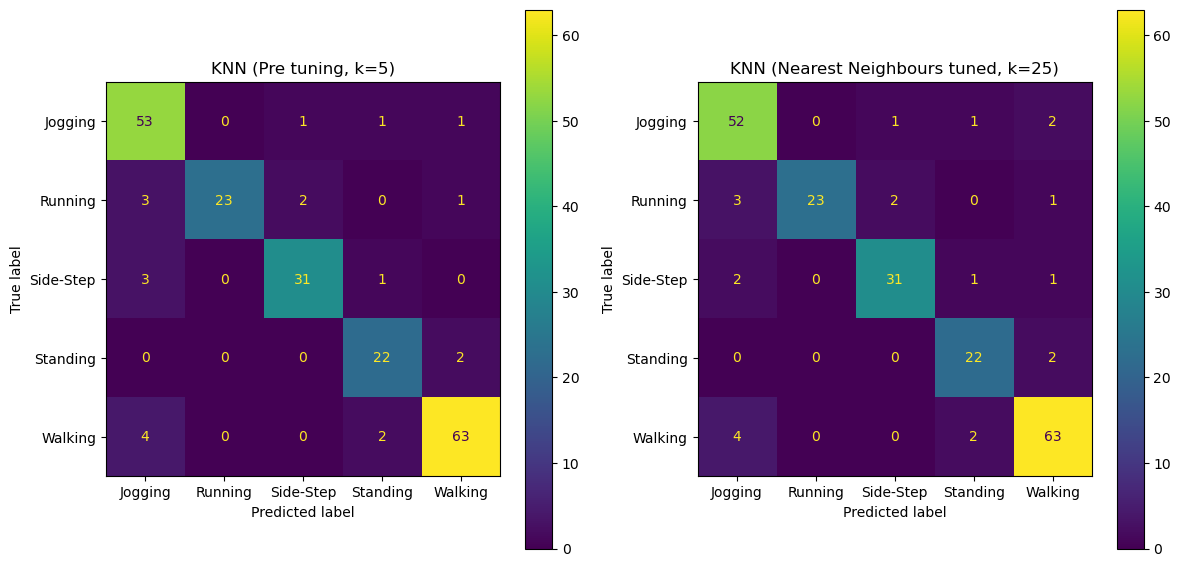

In [801]:
# Call the plot matrix function and pass in our pre and post tuned knn classifiers
plot_confusion_matrix(knn_classifiers, y_test)

Similarly, in conjunction to previous performance metric results, the confusion matrix also demonstrate that tuning the k value (nearest neighbour) didnt affect the overall performance <br>
significantly. We can observe that it makes more mistakes in classifying jogging compared to the pre-tuned confusion matrix, and it makes the same amount of correct predictions as the <br>pre-tuned in other classes, showing no difference.




#### Decision Boundaries Comparison

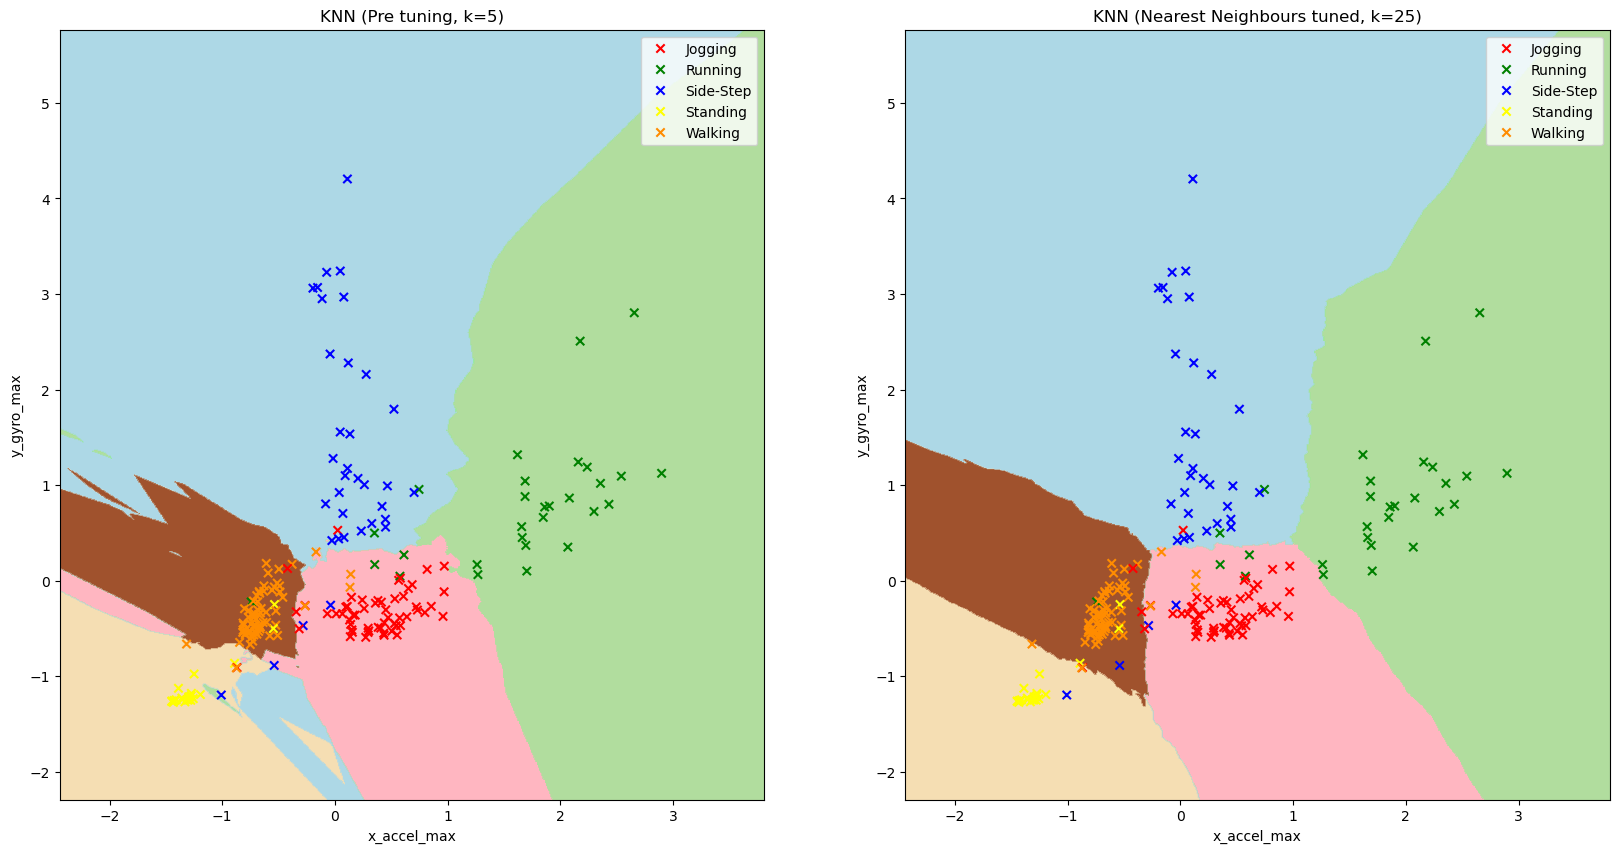

In [804]:
# Call our plot boundaries function, passing in the knn classifiers pre and post tuning
plot_boundaries(knn_classifiers, y_train, y_test)

Comparing the decision plots of the pre-tuned and tuned knn side-by-side, the tuned knn model performs well as is more smoother and does not have extreme jagged borders in comparison.<br>
The decision boundaries are also consistent unlike the pre-tuned graph, where we see the pink and blue boundaries appearing at random points.  <br>
These visualisations demonstrate that the pre-tuned model is overfitting to the data, whereas the tuned knn model highlights better performance in classifying data.

### SGD

#### Finding optimal hyperparameter alpha

The learning rate (alpha) affects how well and the speed at which the model learns the data. If the learning rate is too high, the model will miss the optimal solution. If it is too low, it will take a longer time to reach the optimal solution or possibly get stuck. By improving the learning rate, we aim to help the model to learn more effectively and reach optimal solution.

In [809]:
# Creating a list of values to tune the classifier on
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1.0]
# Creating adictionary to store the results from the above values
results = {}

# Iterate through each value in out list
for alpha in alpha_values:

    # Fit an sgd classifier with each value
    clf = SGDClassifier(alpha=alpha, random_state=42)

    # Get the cross val scores and store it in our dictionary
    scores = cross_val_score(clf, sgdc_X_train_selected, y_train, cv=5, scoring='f1_macro')
    mean_accuracy = np.mean(scores)
    results[alpha] = mean_accuracy

# Iterate through our dictionary to print our results
for alpha, accuracy in results.items():
    print(f"Alpha: {alpha}, Mean Accuracy: {accuracy:.4f}")

# Set the best alpha from the max value in the dictionary
best_alpha = max(results, key=results.get)
print(f"Best Alpha: {best_alpha}, Accuracy: {results[best_alpha]:.4f}")

# Train our sgd on the returned results from above
sgd_tuned = SGDClassifier(alpha=best_alpha, max_iter=1000, random_state=42)
sgd_tuned = best_sgd_clf.fit(sgdc_X_train_selected, y_train)

Alpha: 0.0001, Mean Accuracy: 0.5776
Alpha: 0.001, Mean Accuracy: 0.7602
Alpha: 0.01, Mean Accuracy: 0.7190
Alpha: 0.1, Mean Accuracy: 0.6299
Alpha: 1.0, Mean Accuracy: 0.6109
Best Alpha: 0.001, Accuracy: 0.7602


#### Performance metrics for re-trained SGD

In [811]:
y_test_pred = best_sgd_clf.predict(sgdc_X_test_selected)

# A dictionary for the knn this time
sgd_classifiers = {"SGD (Pre tuning)": [sgd_classifier, sgdc_X_train_selected, sgdc_X_test_selected],
               "SGD (Alpha tuned)": [sgd_tuned, sgdc_X_train_selected, sgdc_X_test_selected]
              }

# using our performance metrics function
performance_metrics(sgd_classifiers, y_train, y_test)

Classifier: 	SGD (Pre tuning)
Accuracy: 	0.5446
Precision: 	0.76554
Recall: 	0.64795
F1 Score: 	0.59341


Classifier: 	SGD (Alpha tuned)
Accuracy: 	0.78404
Precision: 	0.82146
Recall: 	0.7664
F1 Score: 	0.77967




As demonstrated in the results, all performance metrics indicate significant improvement of the SGD classifier with the optimal learning rate. 

#### Visualisation of re-learnt SGD

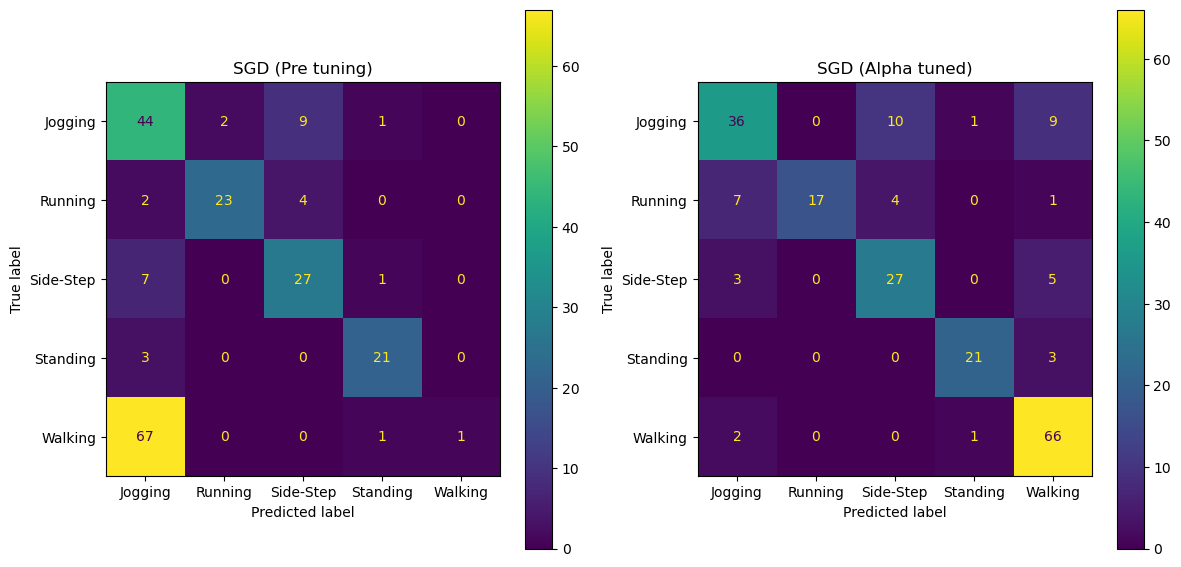

In [815]:
# Plot the confusion matrix's for the sgd
plot_confusion_matrix(sgd_classifiers, y_test)

Jogging class: 36 post-tuned vs 44 pre-tuned correct predictions <br>
Running class: 17 post-tuned vs 23 pre-tuned correct predictions <br>
Side-step class: 27 post-tuned vs 27 pre-tuned correct predictions - same <br>
Standing class: 21 post-tuned vs 21 pre-tuned - same <br>
Walking class: 66 post-tuned vs 1 pre-tuned<br>

These results indicate that the post-tuned model made fewer correct predictions in the jogging and running class, but did exceptionally well in the walking class (66) compared to <br>
pre-tuned(1). This may explain the increase in performance metric scores seen prior, showcasing a better generalisation across the dataset.

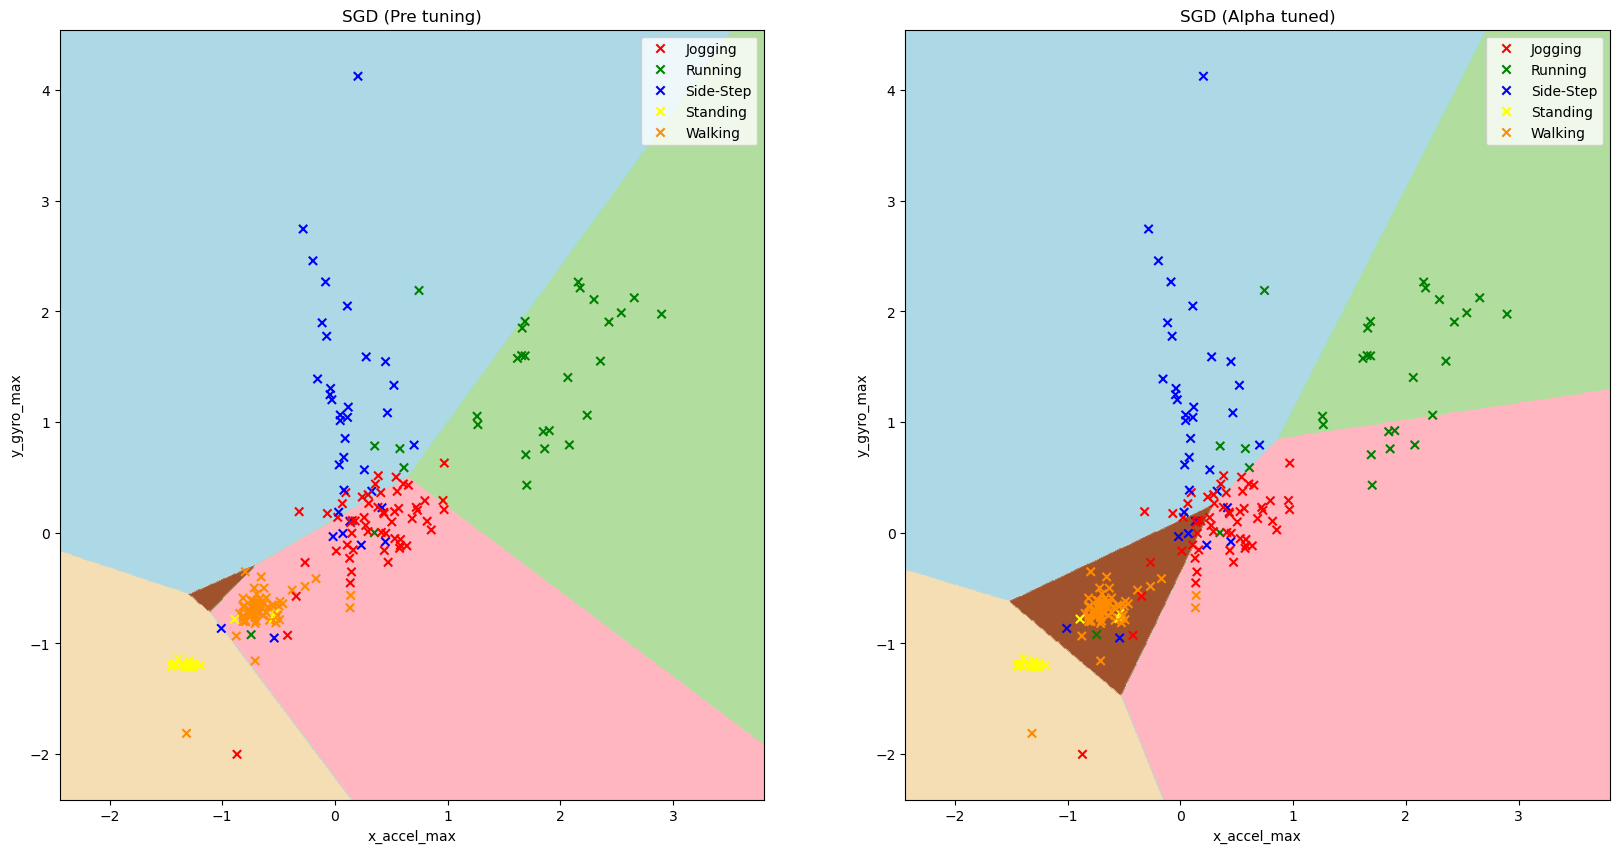

In [818]:
# Call our plot boundaries function, passing in the knn classifiers pre and post tuning
plot_boundaries(sgd_classifiers, y_train, y_test)

As you can see from the above decision boundary plots, there was a huge misclassification with walking and jogging on the pre tuned classifier. Since attempting to tune <br>
the models alpha value, we've seen a significant increase in the models performance metrics. This is most likely due to alpha being a parameter that helps tune regularization <br>
of a model. The original model was using the default value which was a factor of 10 smaller than the tuned model. This seems to have been enough to help the model generalize <br>
better and capture the walking points more correctly by expanding all of the models boundaries (generalizing). Why was this an issue in the first place? Perhaps training our <br>
SGD on just two features was not the best of ideas as it has had a hard time classifying between running and jogging, when as you can see on the decision boundaries, the data <br>
points from our feature set for jogging (red) and walking (orange) are clearly separated and therefore shouldn't have had a hard time initially classifying these activities.


### RandomForest


#### Finding optimal hyperparameter n_estimator and max_features

n_estimators how many trees used to make predictions. Too many trees lead to overfitting, and too few trees lead to underfitting. max_features refer to the number of features considered for best prediction.

In [824]:
# Parameters to tune and thier values
n_estimators_range = [100, 200, 300, 500, 1000]
max_features_range = ['sqrt', 'log2', None]

# A list the hold the score results
results = []

# Iterate over every possible combination of our two parameters
for n_estimators in n_estimators_range:
    for max_features in max_features_range:

        # Fit the classifier with the iterated values
        clf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=42)
        
        #k-fold cross-validation
        scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy') 
        
        #mean accuracy
        mean_accuracy = np.mean(scores)

        # Append the results as a dictionary entry into our list
        results.append({
            'n_estimators': n_estimators,
            'max_features': max_features,
            'mean_accuracy': mean_accuracy
        })

# Get the best result
best_result = max(results, key=lambda x: x['mean_accuracy'])

# Print out the results
print(f"Best Parameters: {best_result['n_estimators']} estimators, {best_result['max_features']} max_features")
print(f"Best Mean Accuracy: {best_result['mean_accuracy']:.4f}")



Best Parameters: 300 estimators, sqrt max_features
Best Mean Accuracy: 0.9436


#### Performance metrics for re-trained RandomForest 

In [829]:
# Create our classifier with the tuned parameters
rf_tuned = RandomForestClassifier(n_estimators=best_result['n_estimators'],
                                  max_features=best_result['max_features'],
                                  random_state=42)

# Fit the classifier with the training data
rf_tuned.fit(X_train, y_train)

# Evaluate on the test set
y_pred = rf_tuned.predict(X_test)

# A dictionary containing our randomforest classifiers
rf_classifiers = {"Random Forest (Pre tuning)": [rf_classifier, X_train, X_test],
               "Random Forest (Max features and Estimators tuned)": [rf_tuned, X_train, X_test]
              }

# performance metrics once again to show us the TRUTH!
performance_metrics(rf_classifiers, y_train, y_test)

Classifier: 	Random Forest (Pre tuning)
Accuracy: 	0.95775
Precision: 	0.95445
Recall: 	0.94612
F1 Score: 	0.95


Classifier: 	Random Forest (Max features and Estimators tuned)
Accuracy: 	0.95775
Precision: 	0.95102
Recall: 	0.94612
F1 Score: 	0.9482




No significant improvement/change observed, scores seem similar across the metrics. However slightly leaning towards pre-tuned, with f1 score of 0.950 vs 0.9482 of post-tuned. <br>
This indicates that the model is robust, as any changes to the hyperparameter did not have a significant impact in its performance. 

#### Visualisation for re-learnt RandomForest

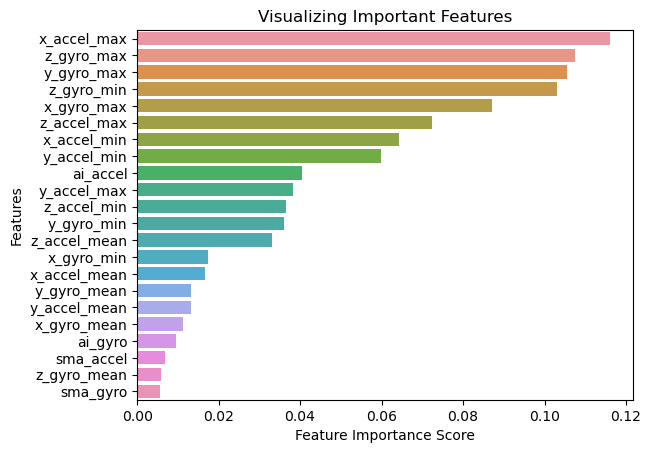

In [910]:
feature_names = X.columns
# Extract feature importances
feature_imp = pd.Series(rf_tuned.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importances
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

The barplot shows which features are important and have the most influence on model prediction. x_accel_max and z_gyro_max have the highest score of ~0.11, in contrast <br>
with sma_gyro, z_gyro_mean that has a score of ~0.005. The low score of the latter reflects the fact that it has almost no influence on the model prediction. <br>

The high score observed in certain features, indicate that the model could be potentially overfitting but as seen with the consistent performance metrics scores,the models<br>
performance did not significantly change even with tuning. Indicating that the model's effectiveness was not affected by potential overfitting.  

# Summary & Concluding thoughts

In this project we were tasked with creating a group of three individuals who had never met before and solve a problem using a complete machine learning workflow from start to end. <br>
We began by importing the data assigned to us, it was in the form of two separate csv files and we had to find a way to combined and align them and use specific pieces of each to create <br>
the final dataset to work on. The key to the this task was time, as in the timestamps that both csv files contained, one in seconds and one in unix time codes, once we got both <br>
dataset on the same page in terms of counting, it was merely a short and simple process of brute forcing which slices of the data we needed to properly align the two sets of data. Next <br>
was creating a set of features to train our classification algorithms on. We chose to just calculate the mean, min, max, average intensity, and signal magnitude with the interest in <br>
calculating more if time permitted. With this task complete it was onto training our classifiers.

We chose to train a Decision Tree, Random Forest, K-nearest Neighbours, and Stocastic Gradient Decent classifiers for the task at hand. We felt this composition of classifiers encompased <br>
a good selection of what we had learnt up to this point of the semester as well as including a linear, non-parametric and ensemble classifier. On the first round of training we stuck to <br>
default values only for all of our classifier, except the decision trees depth. This was because it's default is none and it was next to impossible to visually show the training of the <br>
decision tree when it endlessly goes 10 - 15 rows deep. We decided to set it to a reasonably small number instead and landed on 2. We also decidied to train the Knn and SGD specifically on<br>
only two features and went about the process of chosing those features via cross validation. The rational for this was fairly simple, we wanted to avoid avoid overfitting where we could <br>
and ensemble classifiers like the Random forest are very good at not falling into overfitting traps on their own as well as decision trees, the danger in over fitting those comes more with <br>
over tuning their parameters, this is a common problem for every classifier. For the Knn, although it can handle datasets with large amounts of features, they often perform better on smaller <br>
subsets from the data, and with the SGD being a linear classifier, we thought that fewer features might be better than many to avoid overfitting and less noise in training the classifier, <br>
thought we soon found out that maybe this was a mistake. That aside, the initial training went well, below is a recap of the results..

In [836]:
#Define classifiers
classifiers = {
    'SGDClassifier' : [sgd_classifier, sgdc_X_train_selected, sgdc_X_test_selected],
    'RandomForest' : [rf_classifier, X_train, X_test],
    'KNNeighbours' : [knn_classifier, knn_X_train_selected, knn_X_test_selected],
    'DecisionTree' : [decision_tree, X_train, X_test],
}

#Call the performance_metrics function with the classifiers
performance_metrics(classifiers, y_train, y_test)

Classifier: 	SGDClassifier
Accuracy: 	0.5446
Precision: 	0.76554
Recall: 	0.64795
F1 Score: 	0.59341


Classifier: 	RandomForest
Accuracy: 	0.95775
Precision: 	0.95445
Recall: 	0.94612
F1 Score: 	0.95


Classifier: 	KNNeighbours
Accuracy: 	0.90141
Precision: 	0.9079
Recall: 	0.89099
F1 Score: 	0.89608


Classifier: 	DecisionTree
Accuracy: 	0.80282
Precision: 	0.63686
Recall: 	0.72992
F1 Score: 	0.67643




As you can see from the above, the Random Forest and Knn classifier's had an easy time classifying our dataset just being trained on default values but the decision tree and especially<br>
the SGD had a very rough time. Although we weren't concerned with initial reaults that much as the whole purpose of this project was to primarily learn but also to retrain our classifiers <br>
on a few of their hyper parameters, which we thought would ultimatly lead to better results. Before we get to the retraining, it is interesting to look at the confusion matrix's for both<br>
the Decision tree and SGD classifier, as they both had the hardest time intially training, and maybe we could learn something about our data.

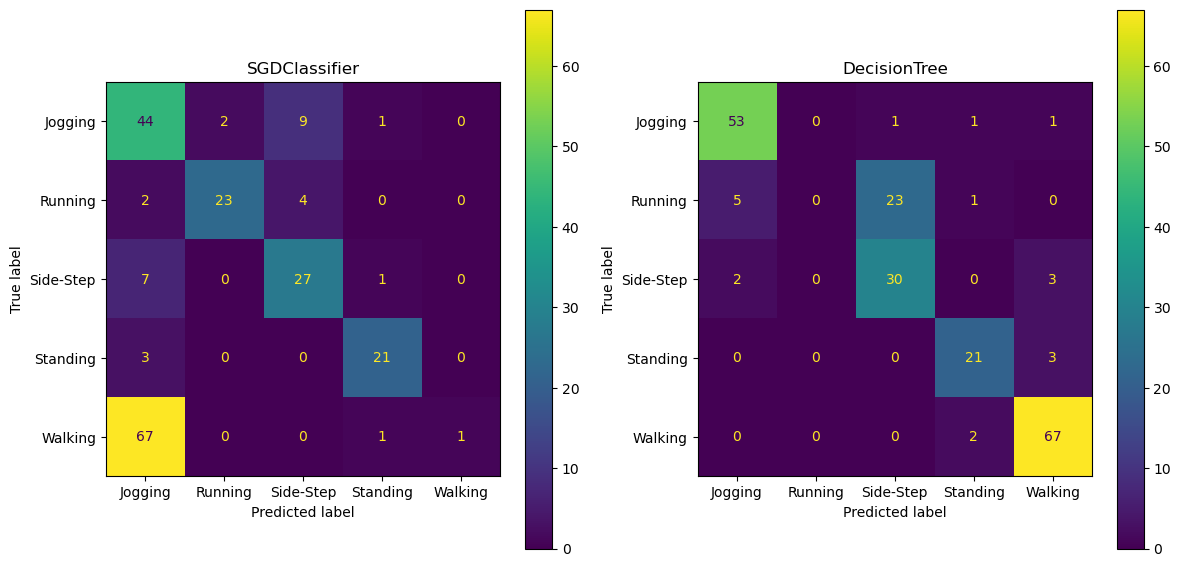

In [839]:
#Define classifiers
classifiers = {
    'SGDClassifier' : [sgd_classifier, sgdc_X_train_selected, sgdc_X_test_selected],
    'DecisionTree' : [decision_tree, X_train, X_test],
    }

plot_confusion_matrix(classifiers, y_test)

Very interesting to see that the SGD has absolutely no idea what walking is, but doesn't do to terribly on every other class, it seems like decerning between walking and jogging <br>
is the only thing really holding it back, the reason for this was most likely feature selection. As for the decision tree, it couldn't figure out what running was, though the reason <br>
for this is more obvious. With only two depths allowed for it's training the data probably hadn't split up enough and when you see that it is misclassifying all running for side steps <br>
it becomes fairly obvious that this was the case as running and side steps most likely share similair velocities in their movement compared to standing walking and even jogging. 

One last thing to note before we move onto hyper parameter tuning is the features that the Knn and SGD selected in their training. Both classifiers opted to use the x-axis acceleration <br>
maximum as the best feature to train on with the SGD opting for the z-axis gyroscope maximum for it's second feature and the knn choosing the y-axis gyroscope maximum.... are you <br>
starting to see the pattern here? It does seem like the maximum values prove to be the most useful when it comes to classifying on this dataset, something to keep in mind as we continue<br>
with hyper parameter tuning.

### DecisionTree Tuning

We finally made it to hyper parameter training and this seemed like a fairly straight forward task, pick the most prominant and useful parameter(s) for each classifier and see if we can <br>
impove on our initial training. The numbers tell a better story than words can, so we will first start with the decision tree and how retraining went for it. Below is the results after <br>
retraining it's max depth parameter, funny enough it selected only 3 for it's optimal depth, which is only 1 more than the orginally trained decision tree. But looking at the results it is <br>
clear that only one more layer of training was required for it to become far more accurate at classifying which activity is which. This goes to show just how powerful of a tool something as <br>
simple as a decision tree algorithm can be. If you look at the confusion matrix we can see it also fixed it's problem between classifying running and side stepping, further highlighting our <br>
above theory that all it needed to do was split the data a little more to decern between the two.

In [845]:
performance_metrics(dtree_classifiers, y_train, y_test)

Classifier: 	Decision Tree (Pre tuning of 2)
Accuracy: 	0.80282
Precision: 	0.63686
Recall: 	0.72992
F1 Score: 	0.67643


Classifier: 	Decision Tree (Max Depth Tuned of 3)
Accuracy: 	0.91549
Precision: 	0.9135
Recall: 	0.894
F1 Score: 	0.90246




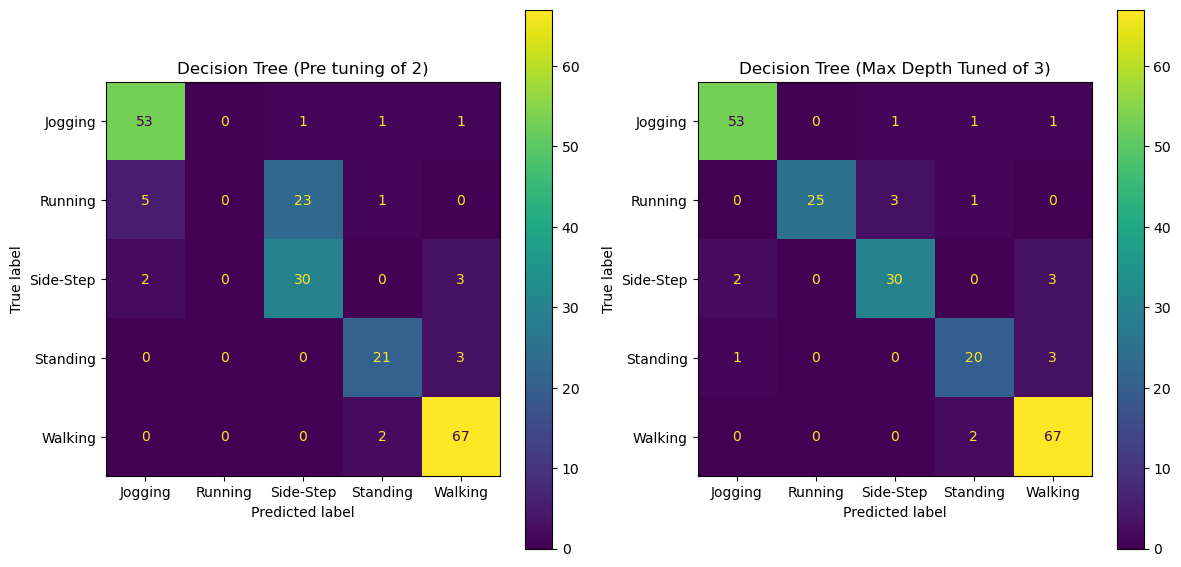

In [846]:
plot_confusion_matrix(dtree_classifiers, y_test)

### Knn Tuning

Next came the Knn classifier and there isn't a whole lot to say about the training for this classifier. We trained it's k value (nearest neighbours) and it chose the value of 25 <br>
which is actually surprisingly good as most knn's will try to select a much smaller number and overfit to the data, but we managed to get it to choose quite a high number for its <br>
nearest neighbours. Unfortunatly this didn't seem to have too much impact on the final results and infact there was practically no improvement for the knn. Perhaps the improvement <br>
could come from training it on more features in general or a different combination of features. Below is a quick recap of its performance metrics before and after training.

In [849]:
performance_metrics(knn_classifiers, y_train, y_test)

Classifier: 	KNN (Pre tuning, k=5)
Accuracy: 	0.90141
Precision: 	0.9079
Recall: 	0.89099
F1 Score: 	0.89608


Classifier: 	KNN (Nearest Neighbours tuned, k=25)
Accuracy: 	0.89671
Precision: 	0.90468
Recall: 	0.88742
F1 Score: 	0.89302




### SGD Tuning

For the SGD classifier their are alot of parameters to choose from to train, we opted for the alpha parameter initially as the alpha helps to regualize models or generalize them better <br>
and since our SGD had such a tough time figuring out the different between walking and jogging (two pretty different things) perhaps generalizing it more may widen the thresholds it is <br>
using when classifying the data. This turned out to be somewhat correct, even though the alpha factor changed only from 0.0001 t0 0.001, this seemed to be enough as you can see below. The <br>
metrics and matix's show a significant increase in score across the board and it has been rid of it's jogging/walking problem. This classifier shows good hope that perhaps we could increase <br>
it's accuracy even by selecting even more parameters to tune, it also shows that perhaps feature selection was the problem for the knn above and perhaps tuning more different parameters may<br>
yeild better results for it too.

In [852]:
performance_metrics(sgd_classifiers, y_train, y_test)

Classifier: 	SGD (Pre tuning)
Accuracy: 	0.5446
Precision: 	0.76554
Recall: 	0.64795
F1 Score: 	0.59341


Classifier: 	SGD (Alpha tuned)
Accuracy: 	0.78404
Precision: 	0.82146
Recall: 	0.7664
F1 Score: 	0.77967




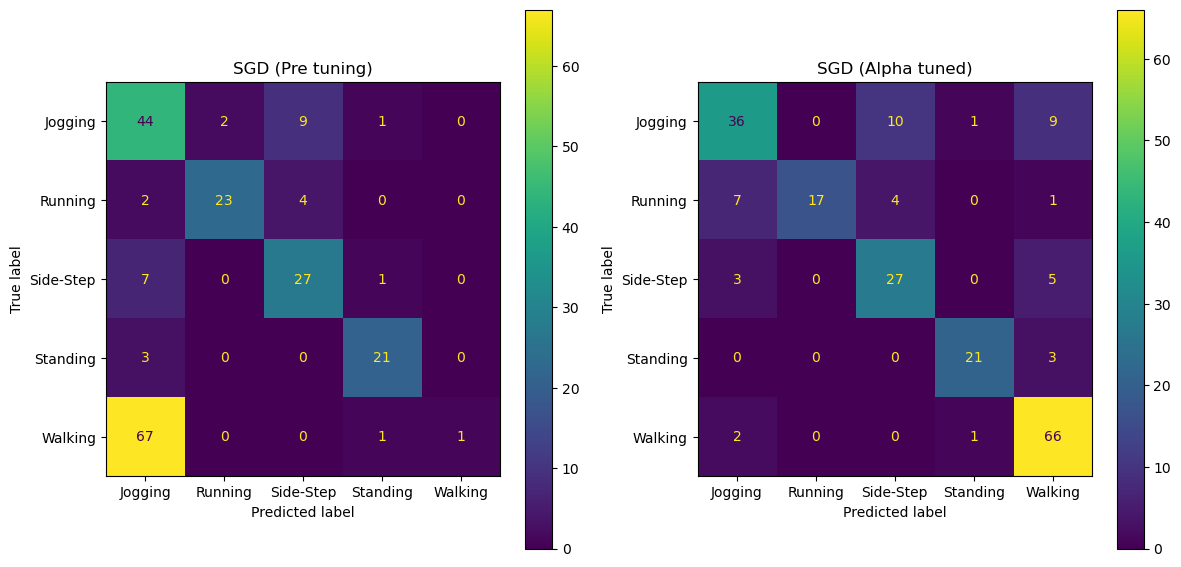

In [853]:
plot_confusion_matrix(sgd_classifiers, y_test)

### Random Forest Tuning

Finally we moved our attention to the Random Forest classifier. The obvious choice of parameter to tune is the number of estimators to use but we also chose to tune its choice <br>
in max features. This returned the default of sqrt, meaning that it would take the sqrt of the number of our features and look at this many feautres when looking to make a split<br>
in decision, for us this number would be 4. Next was the estimators, it chose 300 which is a rather large number but this didn't realy seem to matter as much like the knn, the <br>
tuning of paramters didn't show to have too much effect on the outcome. As seen in the metrics nothing really changed, this may be due to the data and the features calculated. <br>
Perhaps since the data isn't too big or too complex and their wasn't too many features, (17 in total) it was trivial for the Random Forest classifier to classify the activity <br>
data and perhaps any more hyper tuning from the start wouldn't have yielded any significant increase in results and potentially only result in further overfitting the classifier<br>
to the training data. 

In [856]:
performance_metrics(rf_classifiers, y_train, y_test)

Classifier: 	Random Forest (Pre tuning)
Accuracy: 	0.95775
Precision: 	0.95445
Recall: 	0.94612
F1 Score: 	0.95


Classifier: 	Random Forest (Max features and Estimators tuned)
Accuracy: 	0.95775
Precision: 	0.95102
Recall: 	0.94612
F1 Score: 	0.9482




One last thing to mention on the Random Forest is what it thought it's most useful features were, the features of most importance... can you guess what they may have been...? <br>
Like the Knn and SGD before it, it too agrees that the x-axis acceleration maximum is the single most important factor to consider when training. It is interesting that all three<br>
classifiers agree on this, but what is even more interesting is the fact that both the z-axis and y-axis gyroscope maximums are it's second and third most important features. <br>
If you recall from just above these values were the second best features for the knn and sgd respectively, further highlighting the importance of these features. Infact 5 of <br>
the top 6 features were maximums of the gyro and acceleration and 6 of the top 10 features we the maximums showing that it was by far the most useful feature in our data set <br>
to help train our classifiers, there is no doubt that in the future, if we were to look to imporove upon the results today, we would be looking to create or manipulate more <br>
features involving the maximum values of the original datasets.

### Fin

I will conclude this conclusion in saying that this was a great concluding project to attempt to complete and feels like a great accomplishment. Not only did it set us new challenges with data<br>
aggregation and force us to learn some more advance ideas and techniques in data science, it also gave us a taste of what it is like to work on a data science project in a small team <br>
where each indiviual can add a little something into the mix to turn a good project into a great one. Though this project has now come to an end, it was a great experience and a valuable <br>
lesson we will take with us as we continue our journey forward.